# Install the changed library (only once)

please install pytorch (https://pytorch.org/) \
e.g., "pip install torch torchvision"

## Download published trained model (If you have your trained model, no need for doing)

In [1]:
# Download published trained model (2.79GB)
!wget "https://dl.fbaipublicfiles.com/fairseq/models/wmt19.de-en.joined-dict.single_model.tar.gz"

--2020-11-09 14:33:17--  https://dl.fbaipublicfiles.com/fairseq/models/wmt19.de-en.joined-dict.single_model.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2992273886 (2.8G) [application/gzip]
Saving to: ‘wmt19.de-en.joined-dict.single_model.tar.gz’

wmt19.de-en.joined- 100%[===================>]   2.79G  9.92MB/s    in 4m 41s  

2020-11-09 14:38:02 (10.2 MB/s) - ‘wmt19.de-en.joined-dict.single_model.tar.gz’ saved [2992273886/2992273886]



# Usage

In [2]:
import torch
from fairseq.models.transformer import TransformerModel

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Load trained model

path = './wmt19.de-en.joined-dict.single_model.tar.gz'

de2en = TransformerModel.from_pretrained(
    model_name_or_path=path,
    tokenizer='moses',
    bpe='fastbpe',
).to(device)

de2en.eval()
print()

In [4]:
de = "Wir glauben nicht, daß wir nur Rosinen herauspicken sollten."
en = "We do not believe that we should cherry-pick."

eos_id = de2en.tgt_dict.index("</s>")

# Get indices and tokenized text
print("De (source)")
print("Raw text:", de)
de_idx = de2en.encode(de).unsqueeze(0).to(device)
print("Indices:", de_idx)
de_toks = [de2en.src_dict[i] for i in de_idx[0]]
print("Tokenized text:", de_toks)

print("\nEn (target)")
print("Raw text:", en)
en_idx = torch.tensor([eos_id] + [de2en.tgt_dict.index(t) for t in de2en.bpe.encode(en).split()]).unsqueeze(0).to(device)
print("Indices:", en_idx)
en_toks = [de2en.tgt_dict[i] for i in en_idx[0]]
print("Tokenized text:", en_toks)

De (source)
Raw text: Wir glauben nicht, daß wir nur Rosinen herauspicken sollten.
Indices: tensor([[  396,  7952,    74,     4,   514,   150,   249,  2759,  4089,   730,
           640,   393, 15810,  1882,     5,     2]], device='cuda:0')
Tokenized text: ['Wir', 'glauben', 'nicht', ',', 'daß', 'wir', 'nur', 'Ros@@', 'inen', 'her@@', 'au@@', 'sp@@', 'icken', 'sollten', '.', '</s>']

En (target)
Raw text: We do not believe that we should cherry-pick.
Indices: tensor([[    2,   333,   283,    90,  2989,    38,   136,   505,   199,  5939,
           167,   406, 21075,     5]], device='cuda:0')
Tokenized text: ['</s>', 'We', 'do', 'not', 'believe', 'that', 'we', 'should', 'ch@@', 'err@@', 'y@@', '-@@', 'pick@@', '.']


### If you want attention weights from all heads, set `output_all_attentions` `True`

In [5]:
with torch.no_grad():
    outputs = de2en.models[0](de_idx, de_idx.size()[-1], en_idx, output_all_attentions=True)

# outputs: (output_states, {"attn": attention_weights, "inner_states": inner_states})

In [6]:
attn = outputs[1]["attn"]

# attn is a tuple which has 6 tensors (equals to the number of decoder layer)
print(len(attn))

for attn in outputs[1]["attn"]:
    print(attn.size())
print("Each tensor's shape is (num_heads, batch_size, target_length, source_length)")

6
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
Each tensor's shape is (num_heads, batch_size, target_length, source_length)


### If you want norms from all heads, set `output_all_norms` `True`

In [7]:
with torch.no_grad():
    outputs = de2en.models[0](de_idx, de_idx.size()[-1], en_idx, output_all_norms=True)

# outputs: (output_states, {"attn": attention_weights, "norms": (||f(x)||, ||αf(x)||, ||Σαf(x)||), "inner_states": inner_states})

In [8]:
# attn is a tuple which has 3 tuples (||f(x)||, ||αf(x)||, ||Σαf(x)||)
norms = outputs[1]["norms"]
print(len(norms))

print("\nnorm of transformed vector ||f(x)||")
transformed_vector_norms = norms[0]
# transformed_vector_norms is a tuple which has 6 tensors (equals to the number of decoder layer)
print(len(transformed_vector_norms))

for norm in transformed_vector_norms:
    print(norm.size())
print("Each tensor's shape is (num_heads, batch_size, source_length)")


print("\nnorm of weighted vector ||αf(x)||")
weighted_vector_norms = norms[1]
# weighted_vector_norms is a tuple which has 6 tensors (equals to the number of decoder layer)
print(len(weighted_vector_norms))

for norm in weighted_vector_norms:
    print(norm.size())
print("Each tensor's shape is (num_heads, batch_size, target_length, source_length)")


print("\nnorm of summed weighted vector ||Σαf(x)||")
summed_weighted_vector_norms = norms[2]
# summed_weighted_vector_norms is a tuple which has 6 tensors (equals to the number of decoder layer)
print(len(summed_weighted_vector_norms))

for norm in summed_weighted_vector_norms:
    print(norm.size())
print("Each tensor's shape is (batch_size, target_length, source_length)")

3

norm of transformed vector ||f(x)||
6
torch.Size([16, 1, 16])
torch.Size([16, 1, 16])
torch.Size([16, 1, 16])
torch.Size([16, 1, 16])
torch.Size([16, 1, 16])
torch.Size([16, 1, 16])
Each tensor's shape is (num_heads, batch_size, source_length)

norm of weighted vector ||αf(x)||
6
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
torch.Size([16, 1, 14, 16])
Each tensor's shape is (num_heads, batch_size, target_length, source_length)

norm of summed weighted vector ||Σαf(x)||
6
torch.Size([1, 14, 16])
torch.Size([1, 14, 16])
torch.Size([1, 14, 16])
torch.Size([1, 14, 16])
torch.Size([1, 14, 16])
torch.Size([1, 14, 16])
Each tensor's shape is (batch_size, target_length, source_length)


## Layer-level Comparison

In [9]:
# output both weights and norms from all heads
with torch.no_grad():
    outputs = de2en.models[0](de_idx, de_idx.size()[-1], en_idx, output_all_attentions=True, output_all_norms=True)

#### attention weight $α$ averaged over all heads in each layer

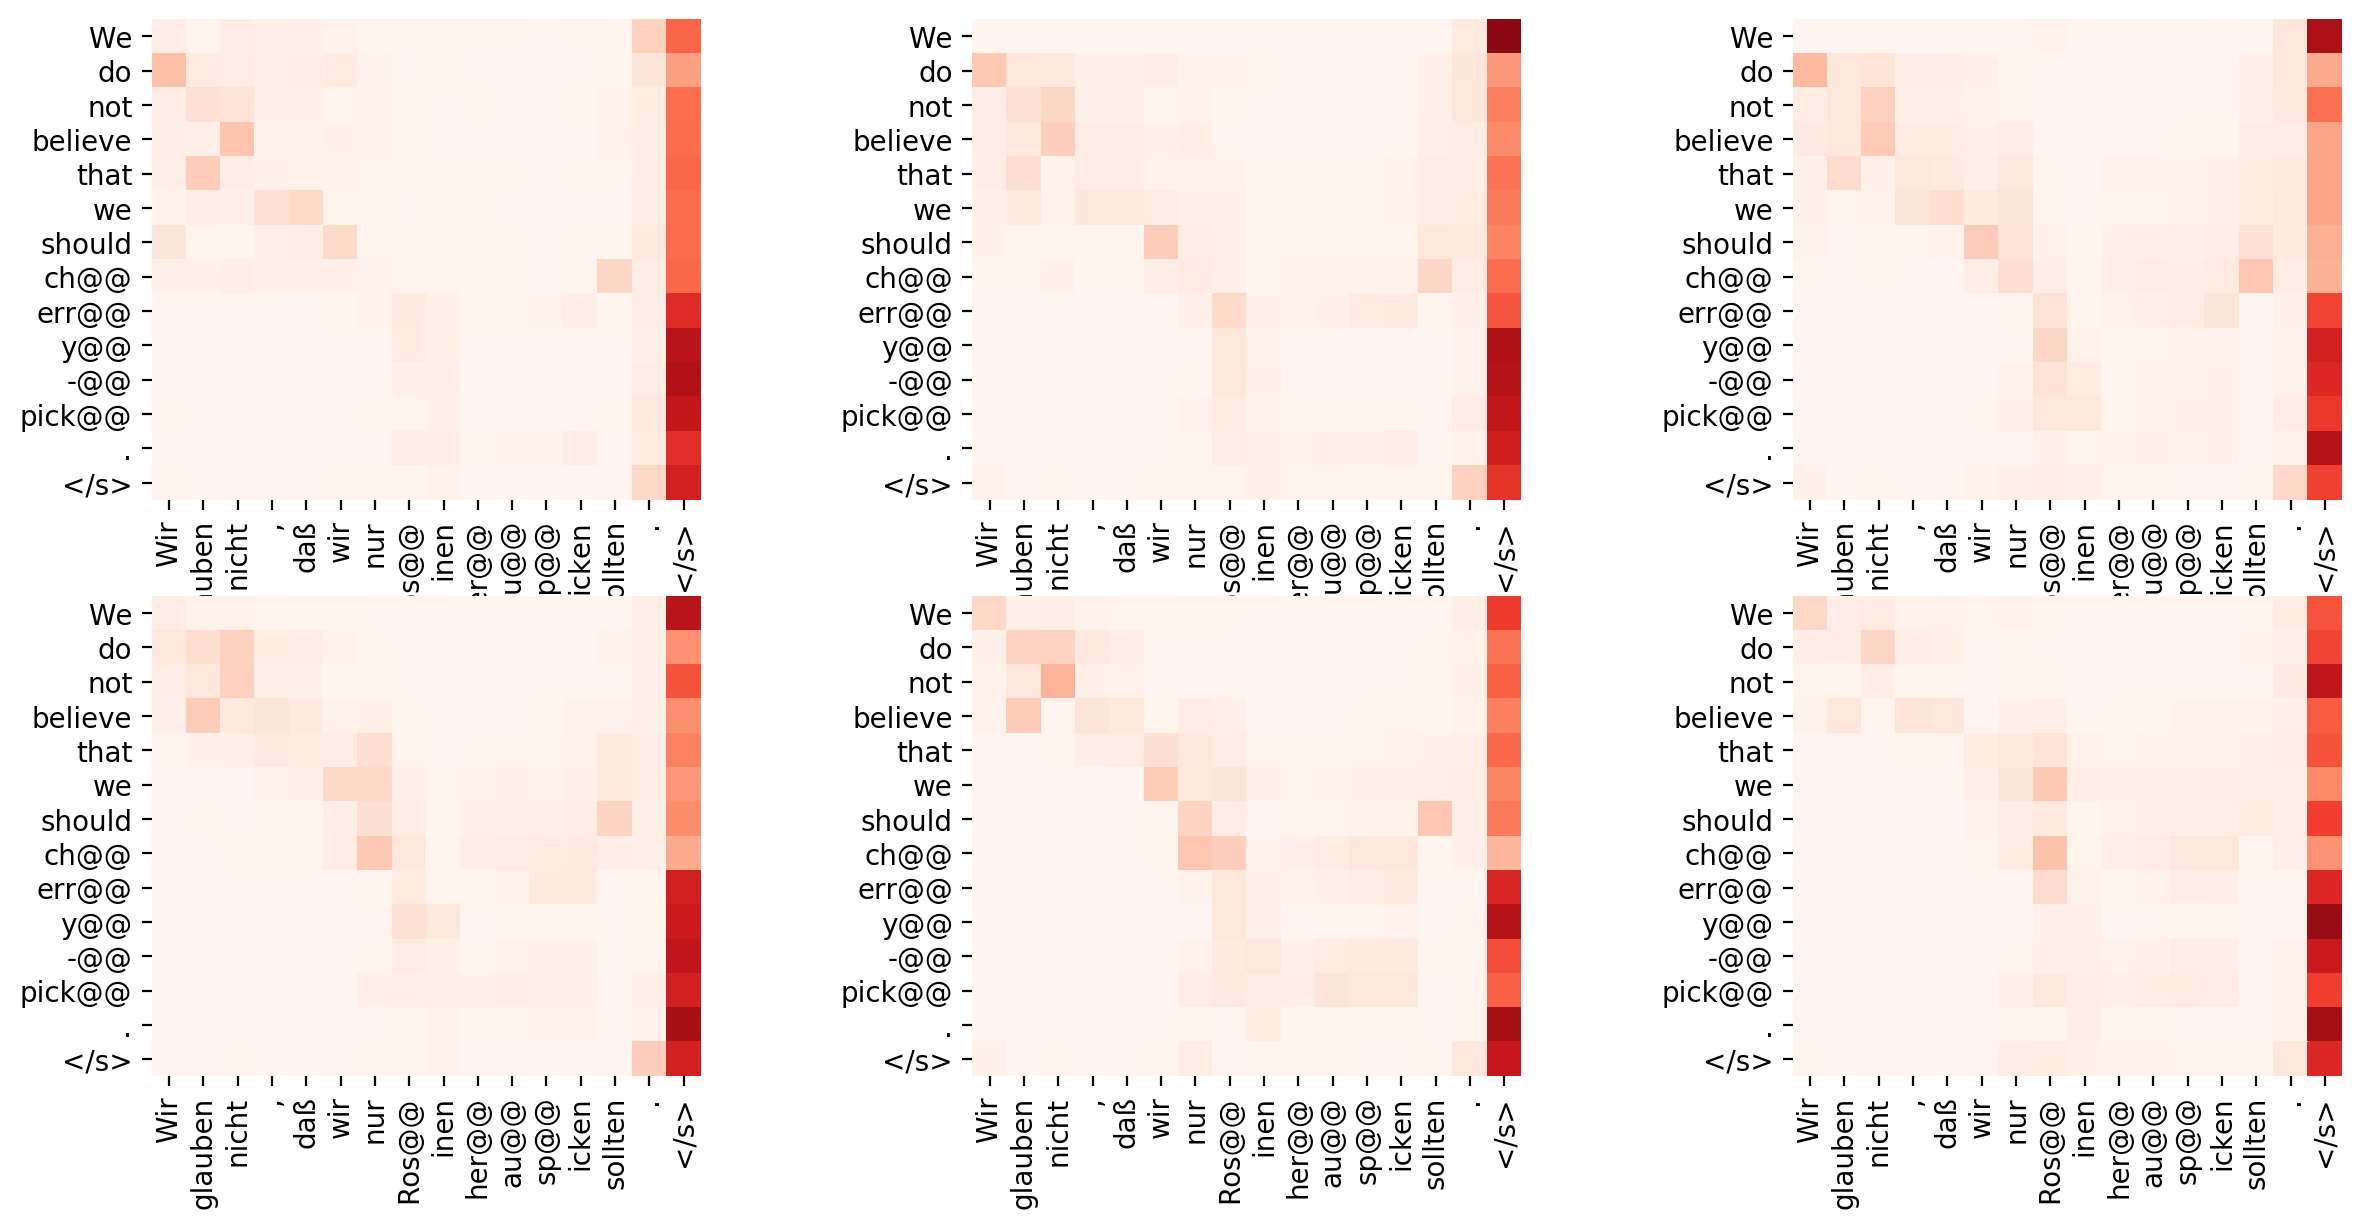

In [10]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, axe = plt.subplots(2, 3, figsize=(15, 7), dpi=200)
for layer in range(6):
    attention = outputs[1]['attn'][layer].mean(dim=0)[0].detach().cpu().numpy()
    df = pd.DataFrame(attention,columns=de_toks,index=en_toks[1:]+['</s>'])
    sns.heatmap(df,vmax=1,cmap="Reds",square=True,cbar=False,ax=axe[int(layer/3)][layer - int(layer/3)*3])
plt.show()

#### norm of summed weighted vector $||\Sigma_{heads} αf(x)||$

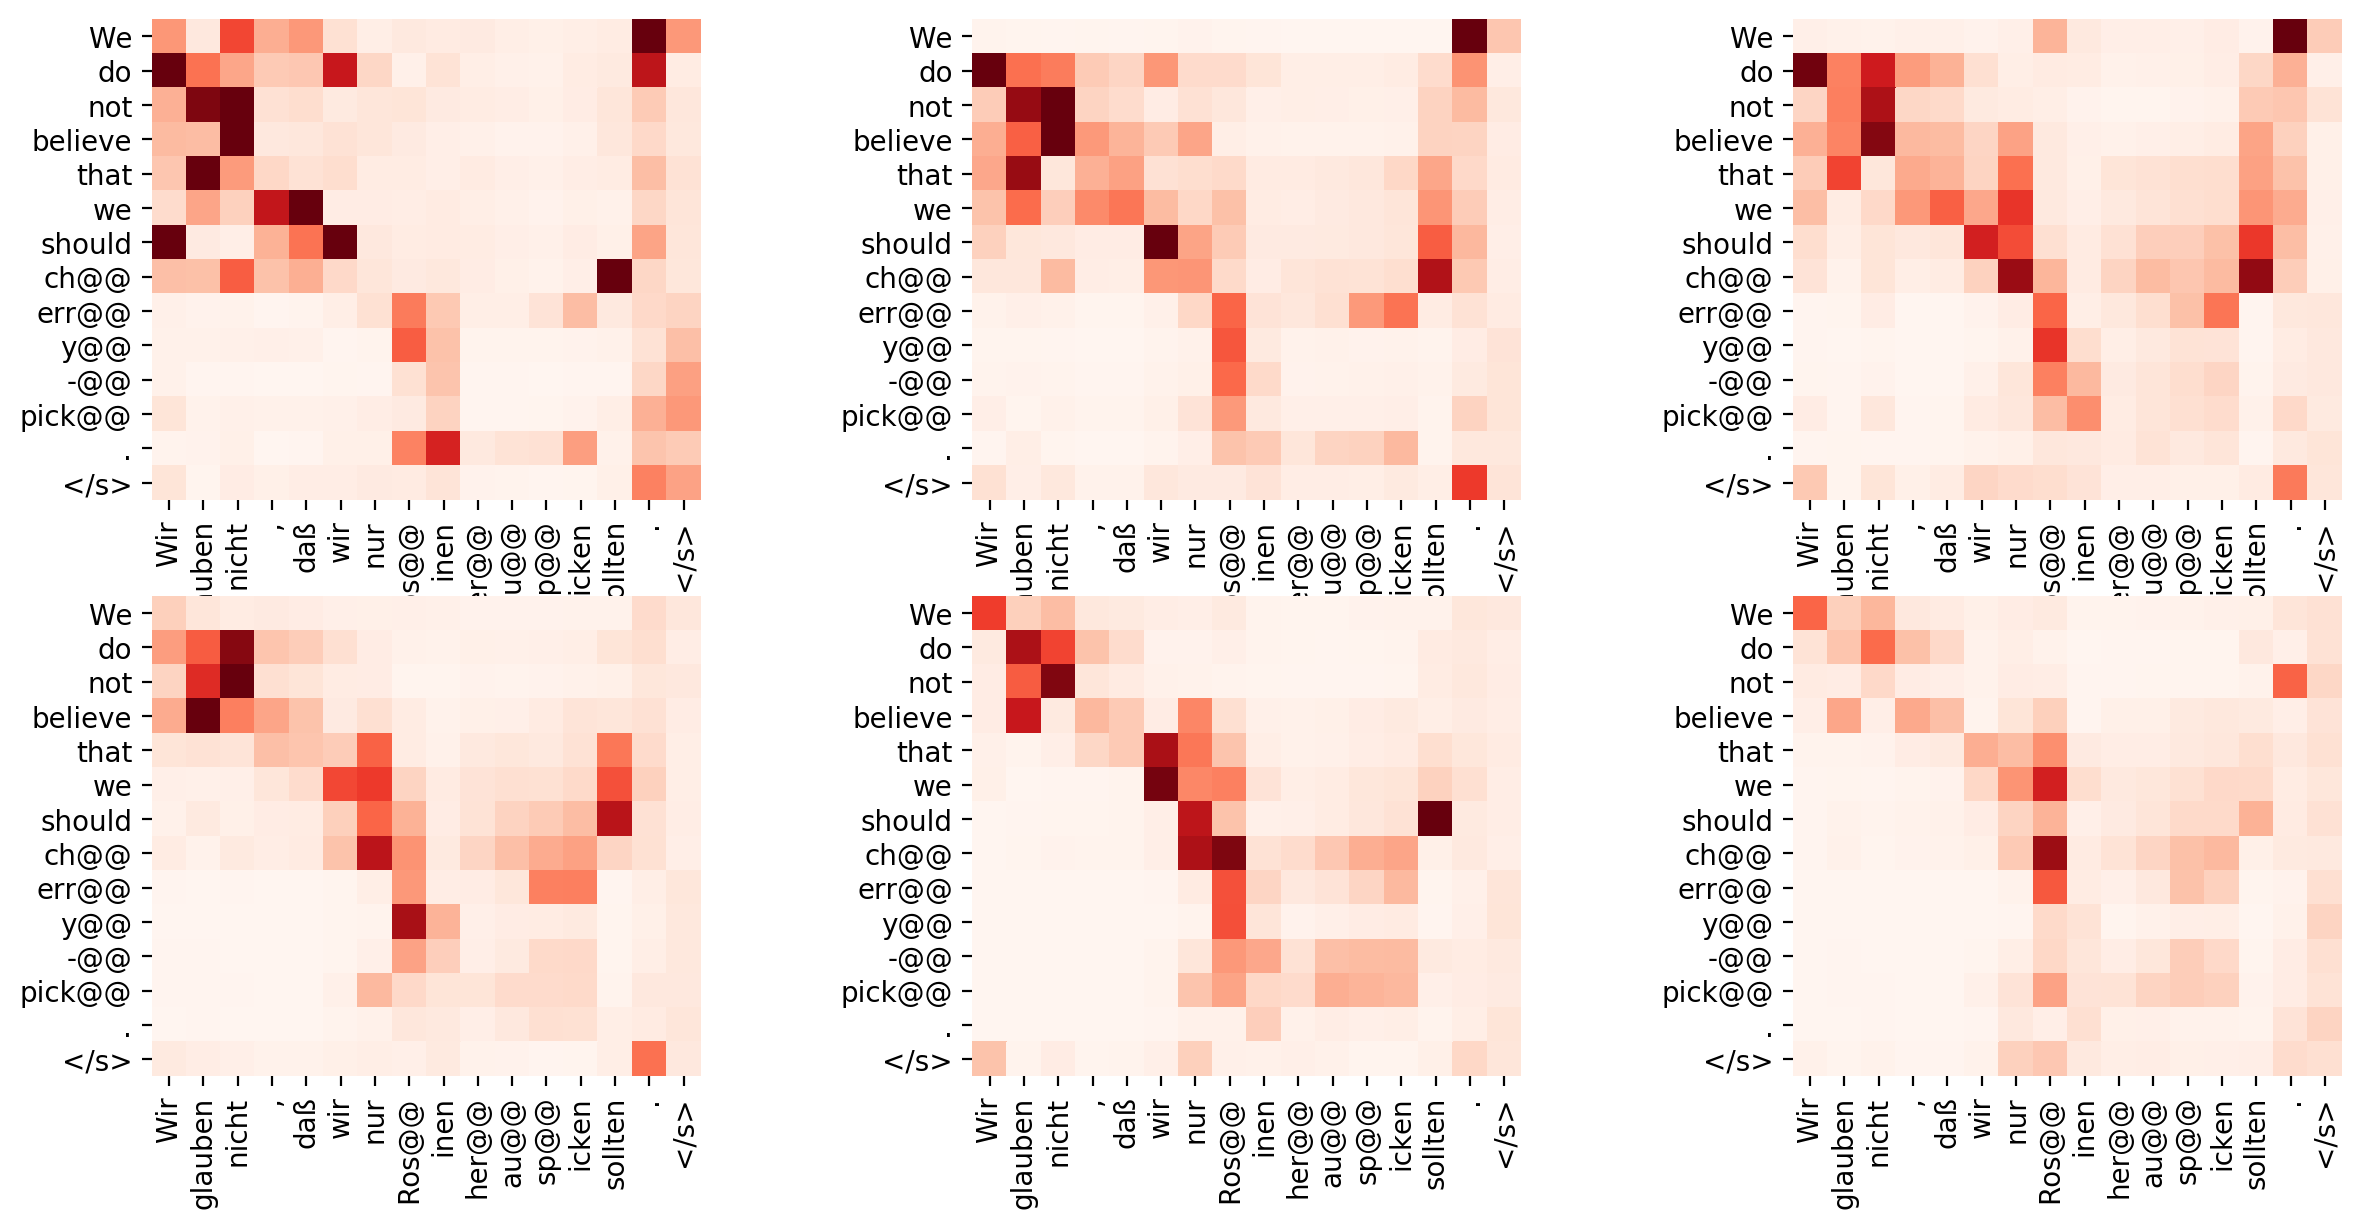

In [11]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

fig, axe = plt.subplots(2, 3, figsize=(15, 7), dpi=200)
for layer in range(6):
    norm = outputs[1]['norms'][2][layer][0].detach().cpu().numpy()
    df = pd.DataFrame(norm,columns=de_toks,index=en_toks[1:]+['</s>'])
    sns.heatmap(df,vmax=10,cmap="Reds",square=True,cbar=False,ax=axe[int(layer/3)][layer - int(layer/3)*3])
plt.show()

## Head-level Comparison

#### attention weight $α$


 1 layer


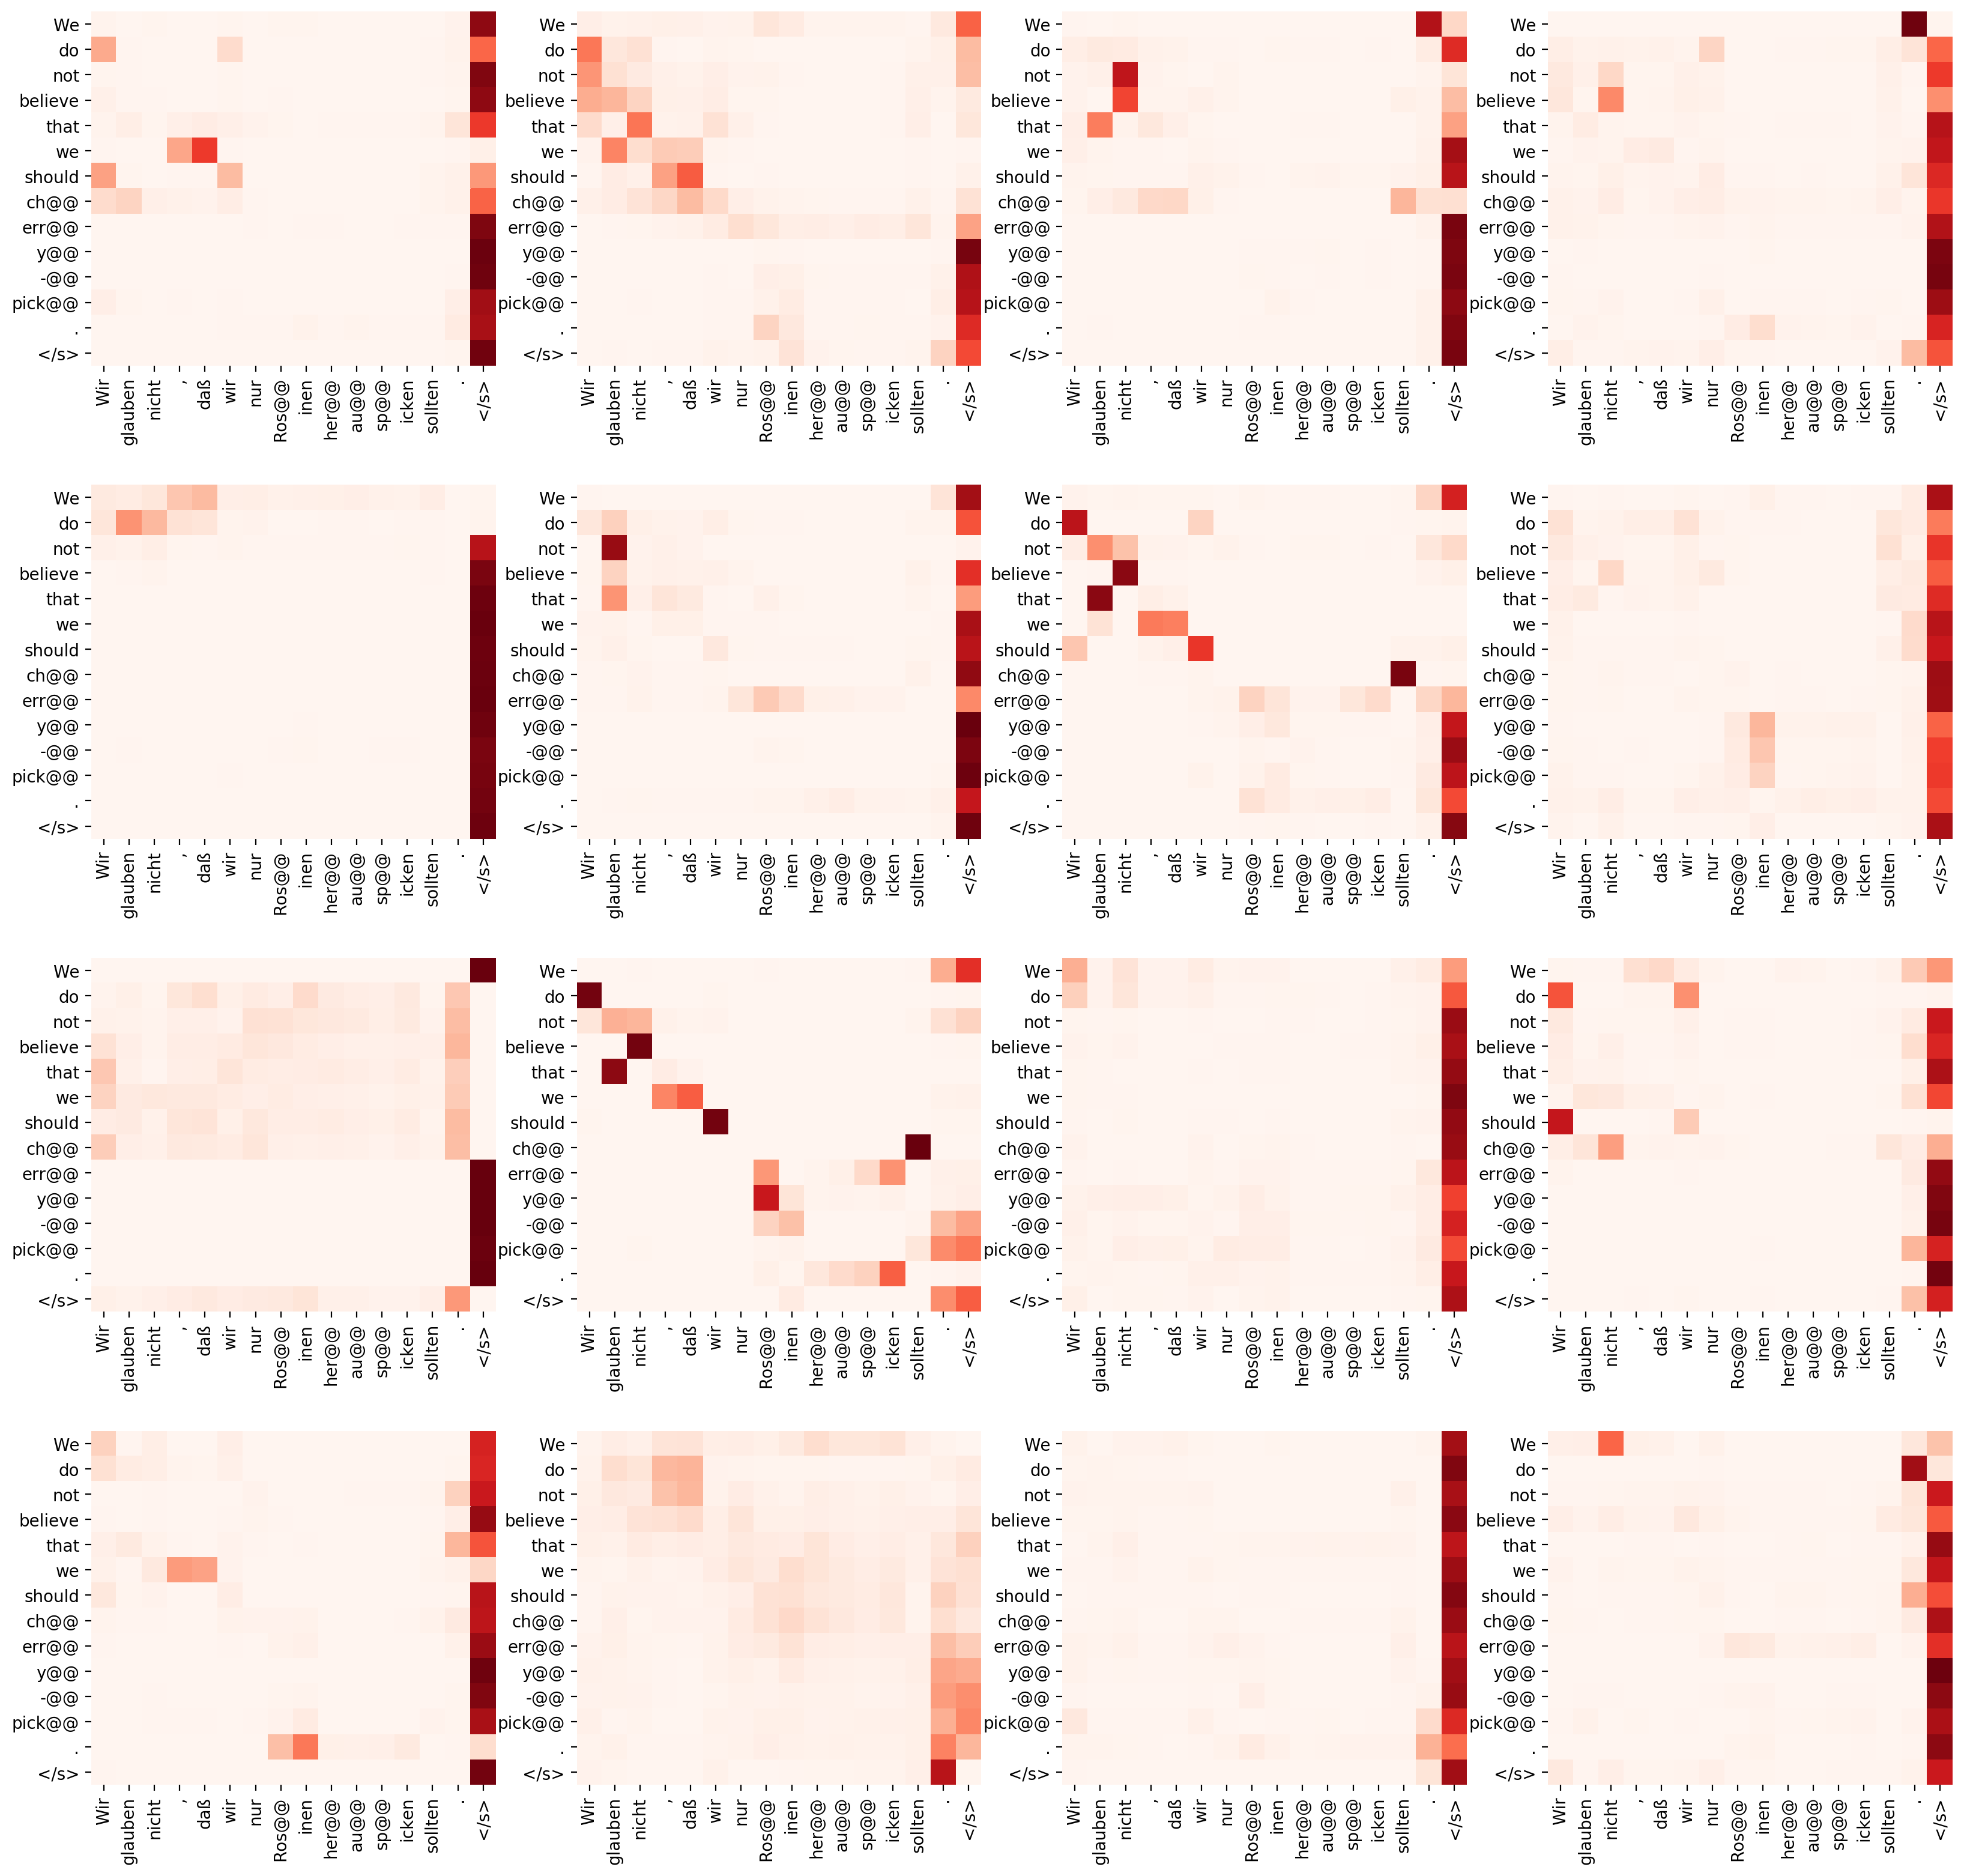


 2 layer


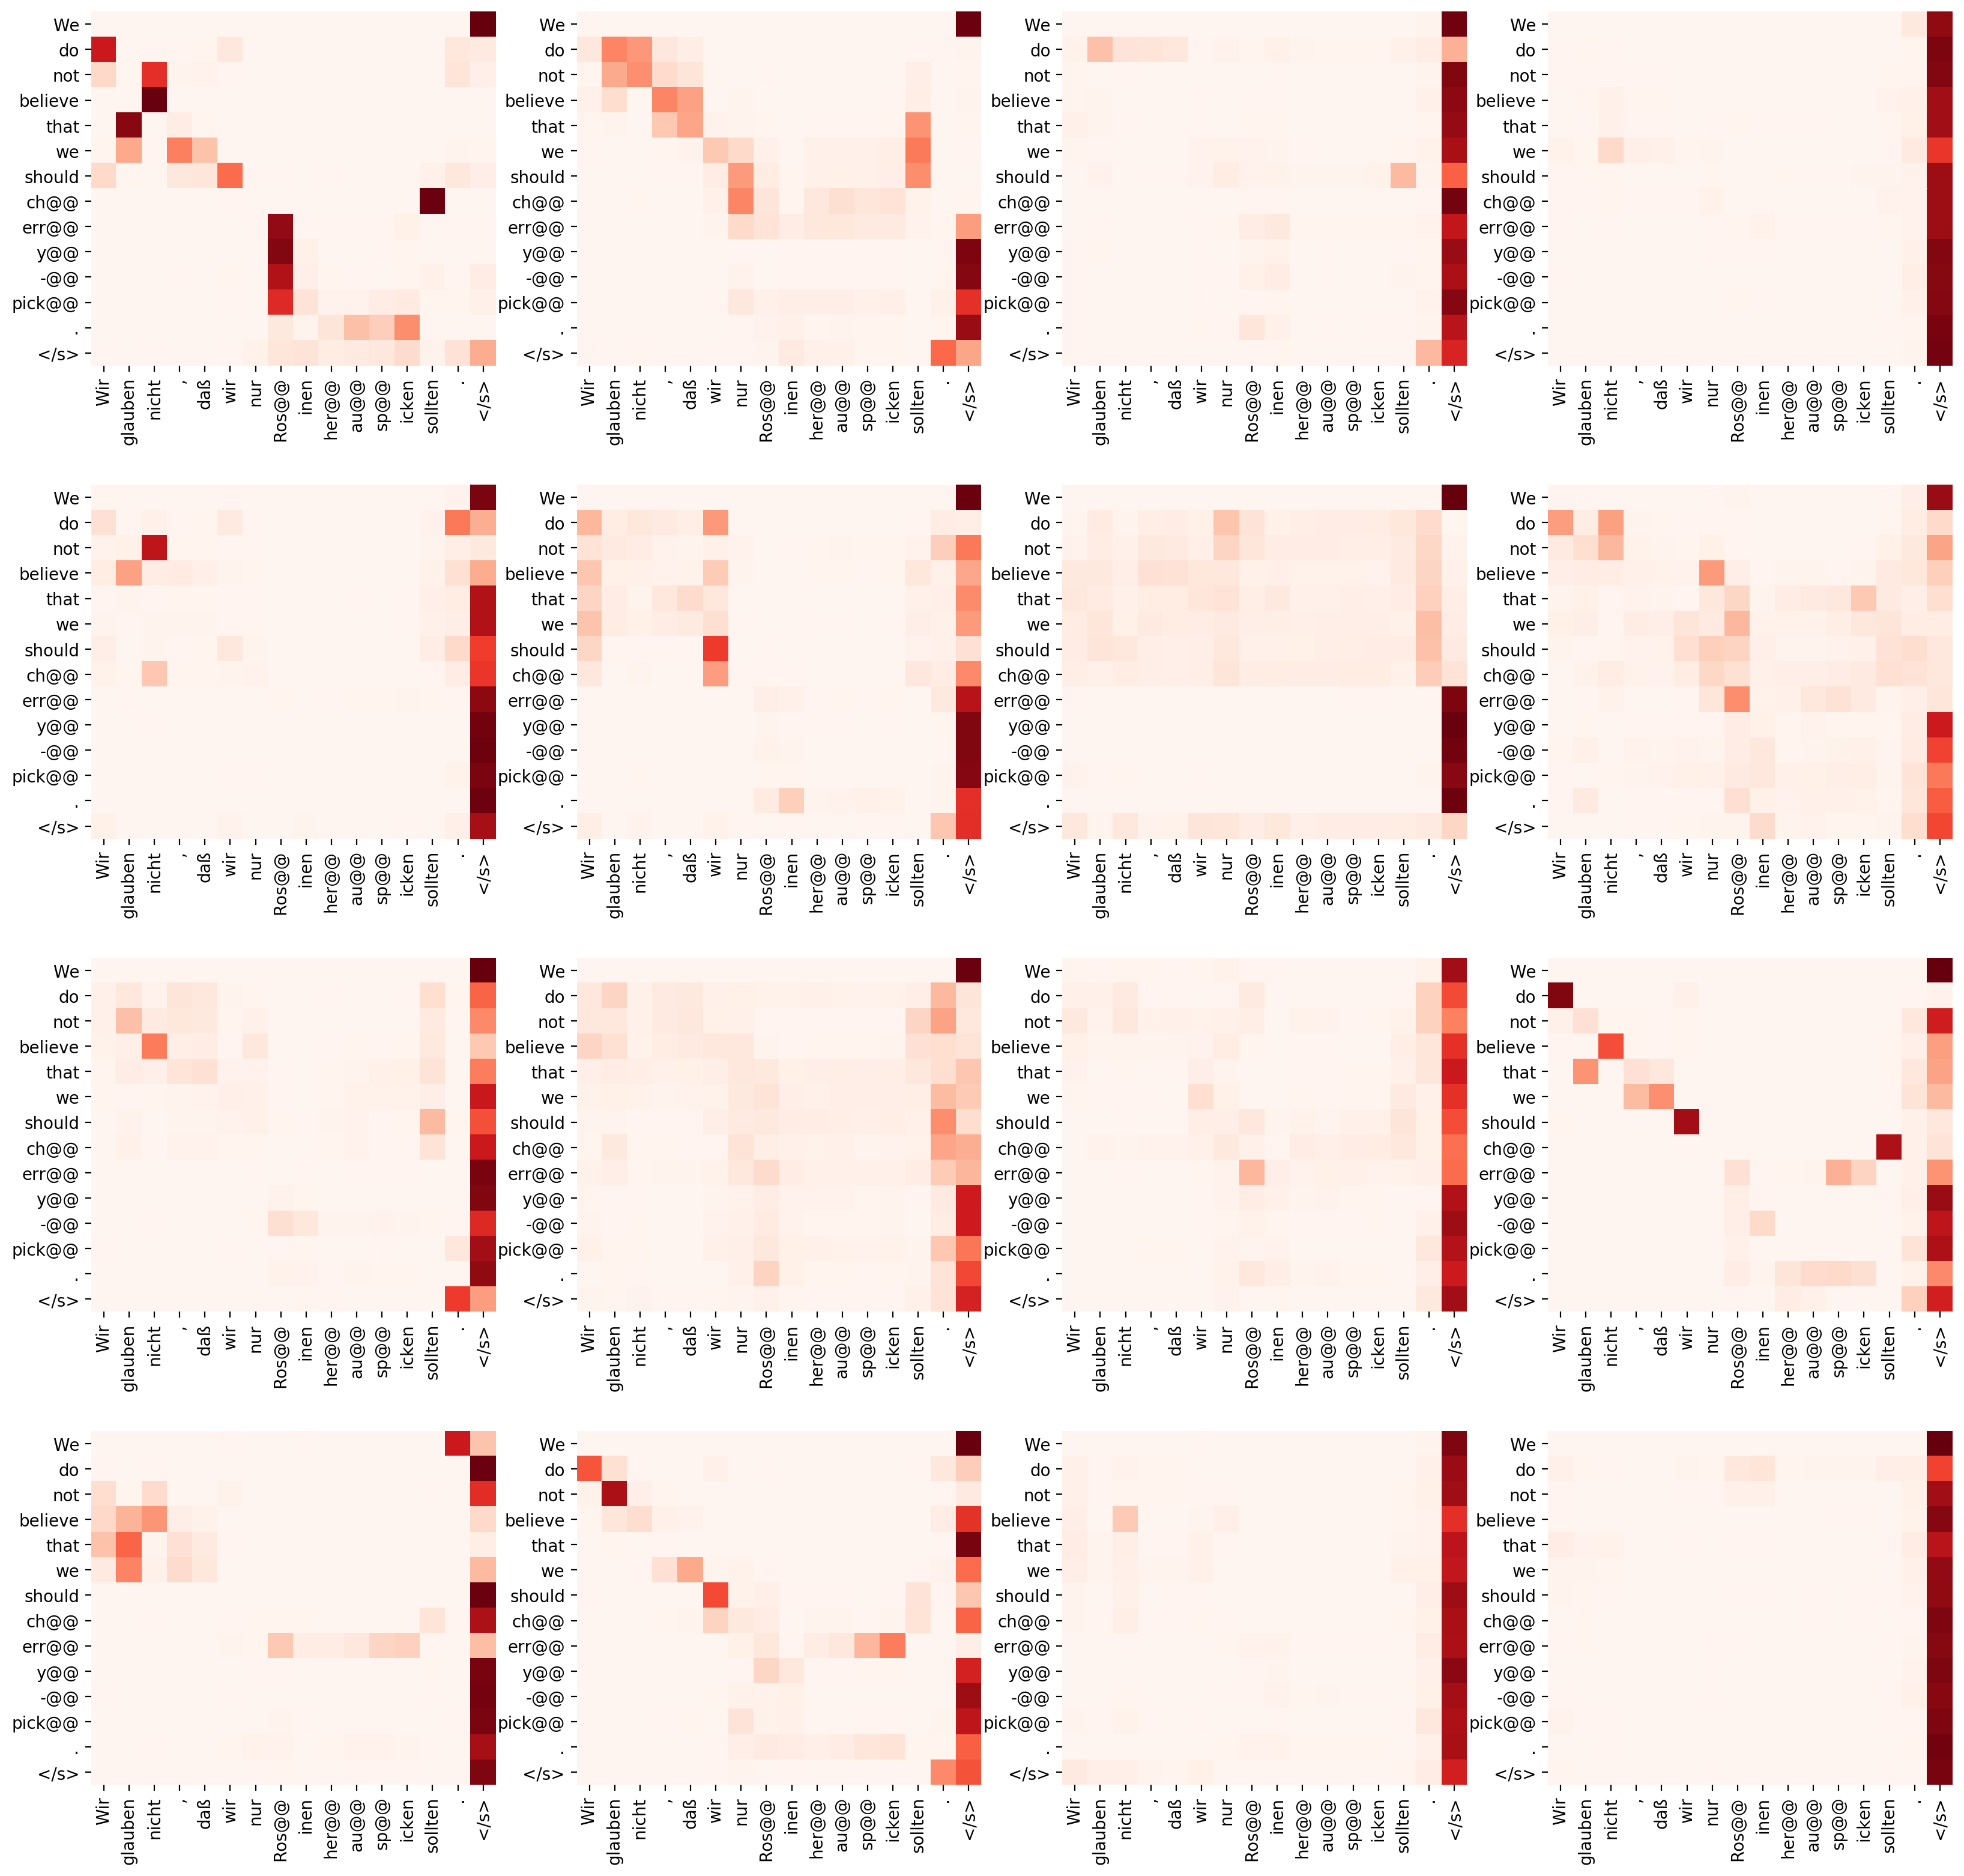


 3 layer


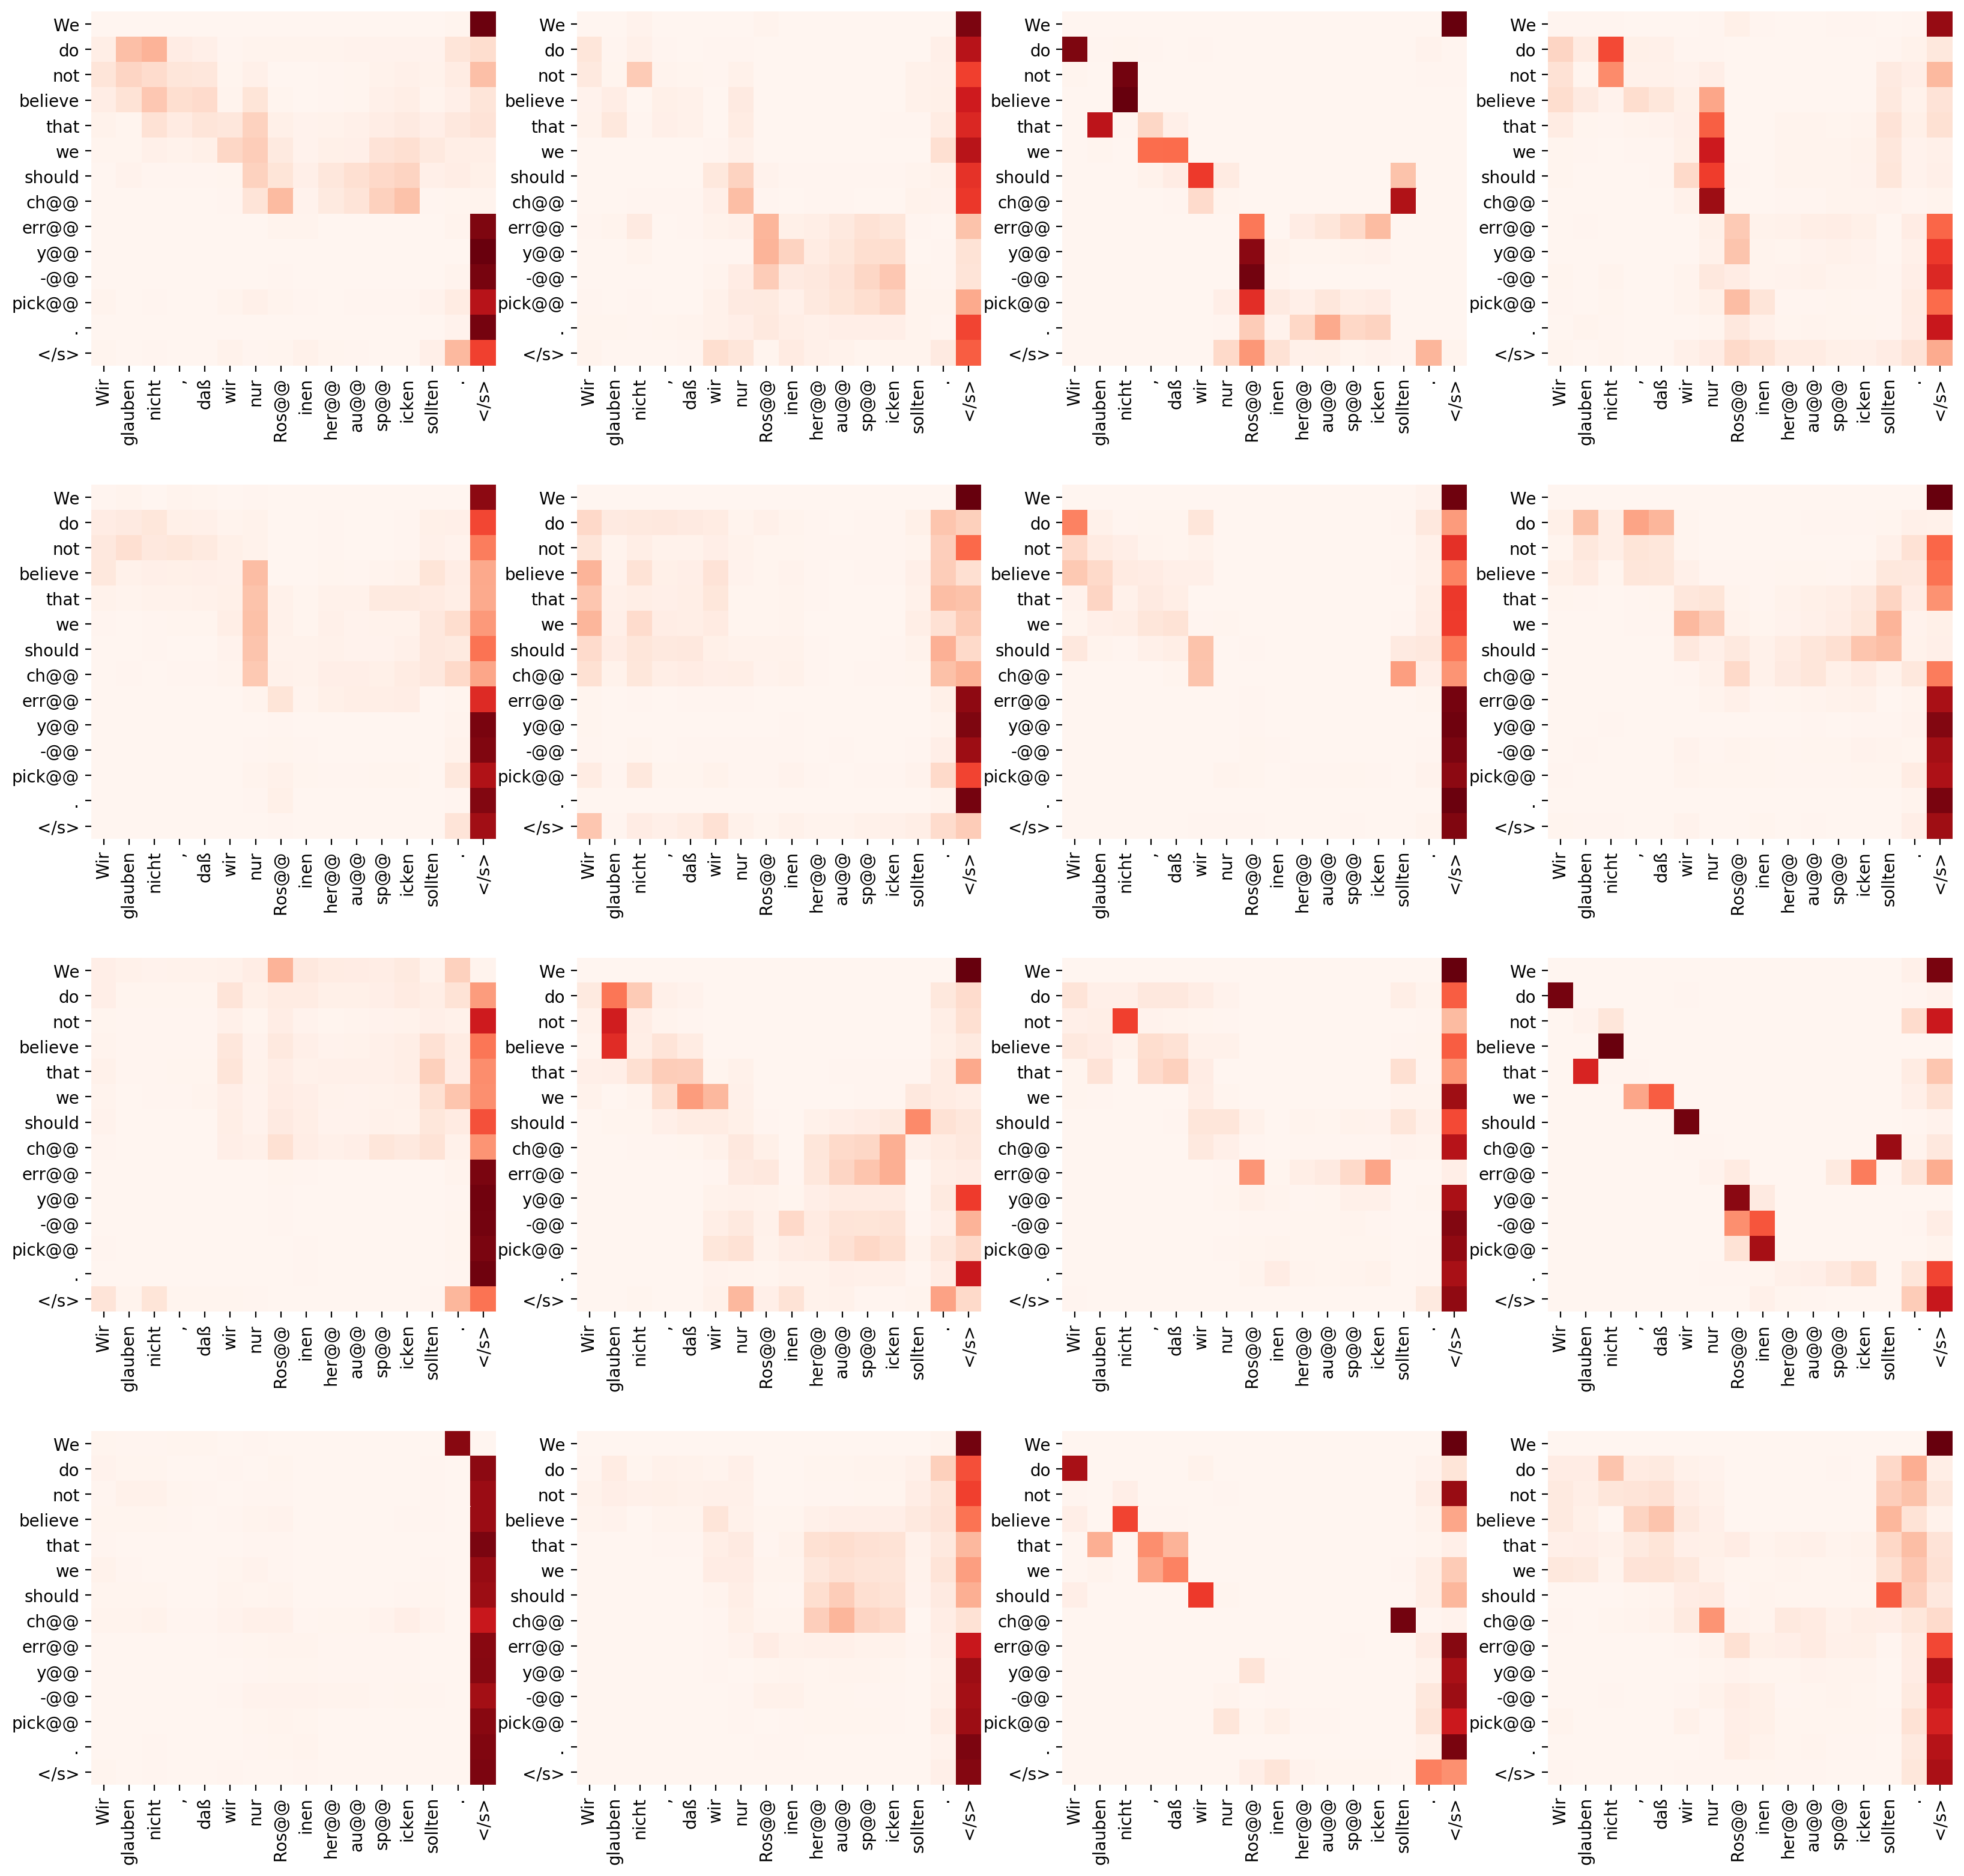


 4 layer


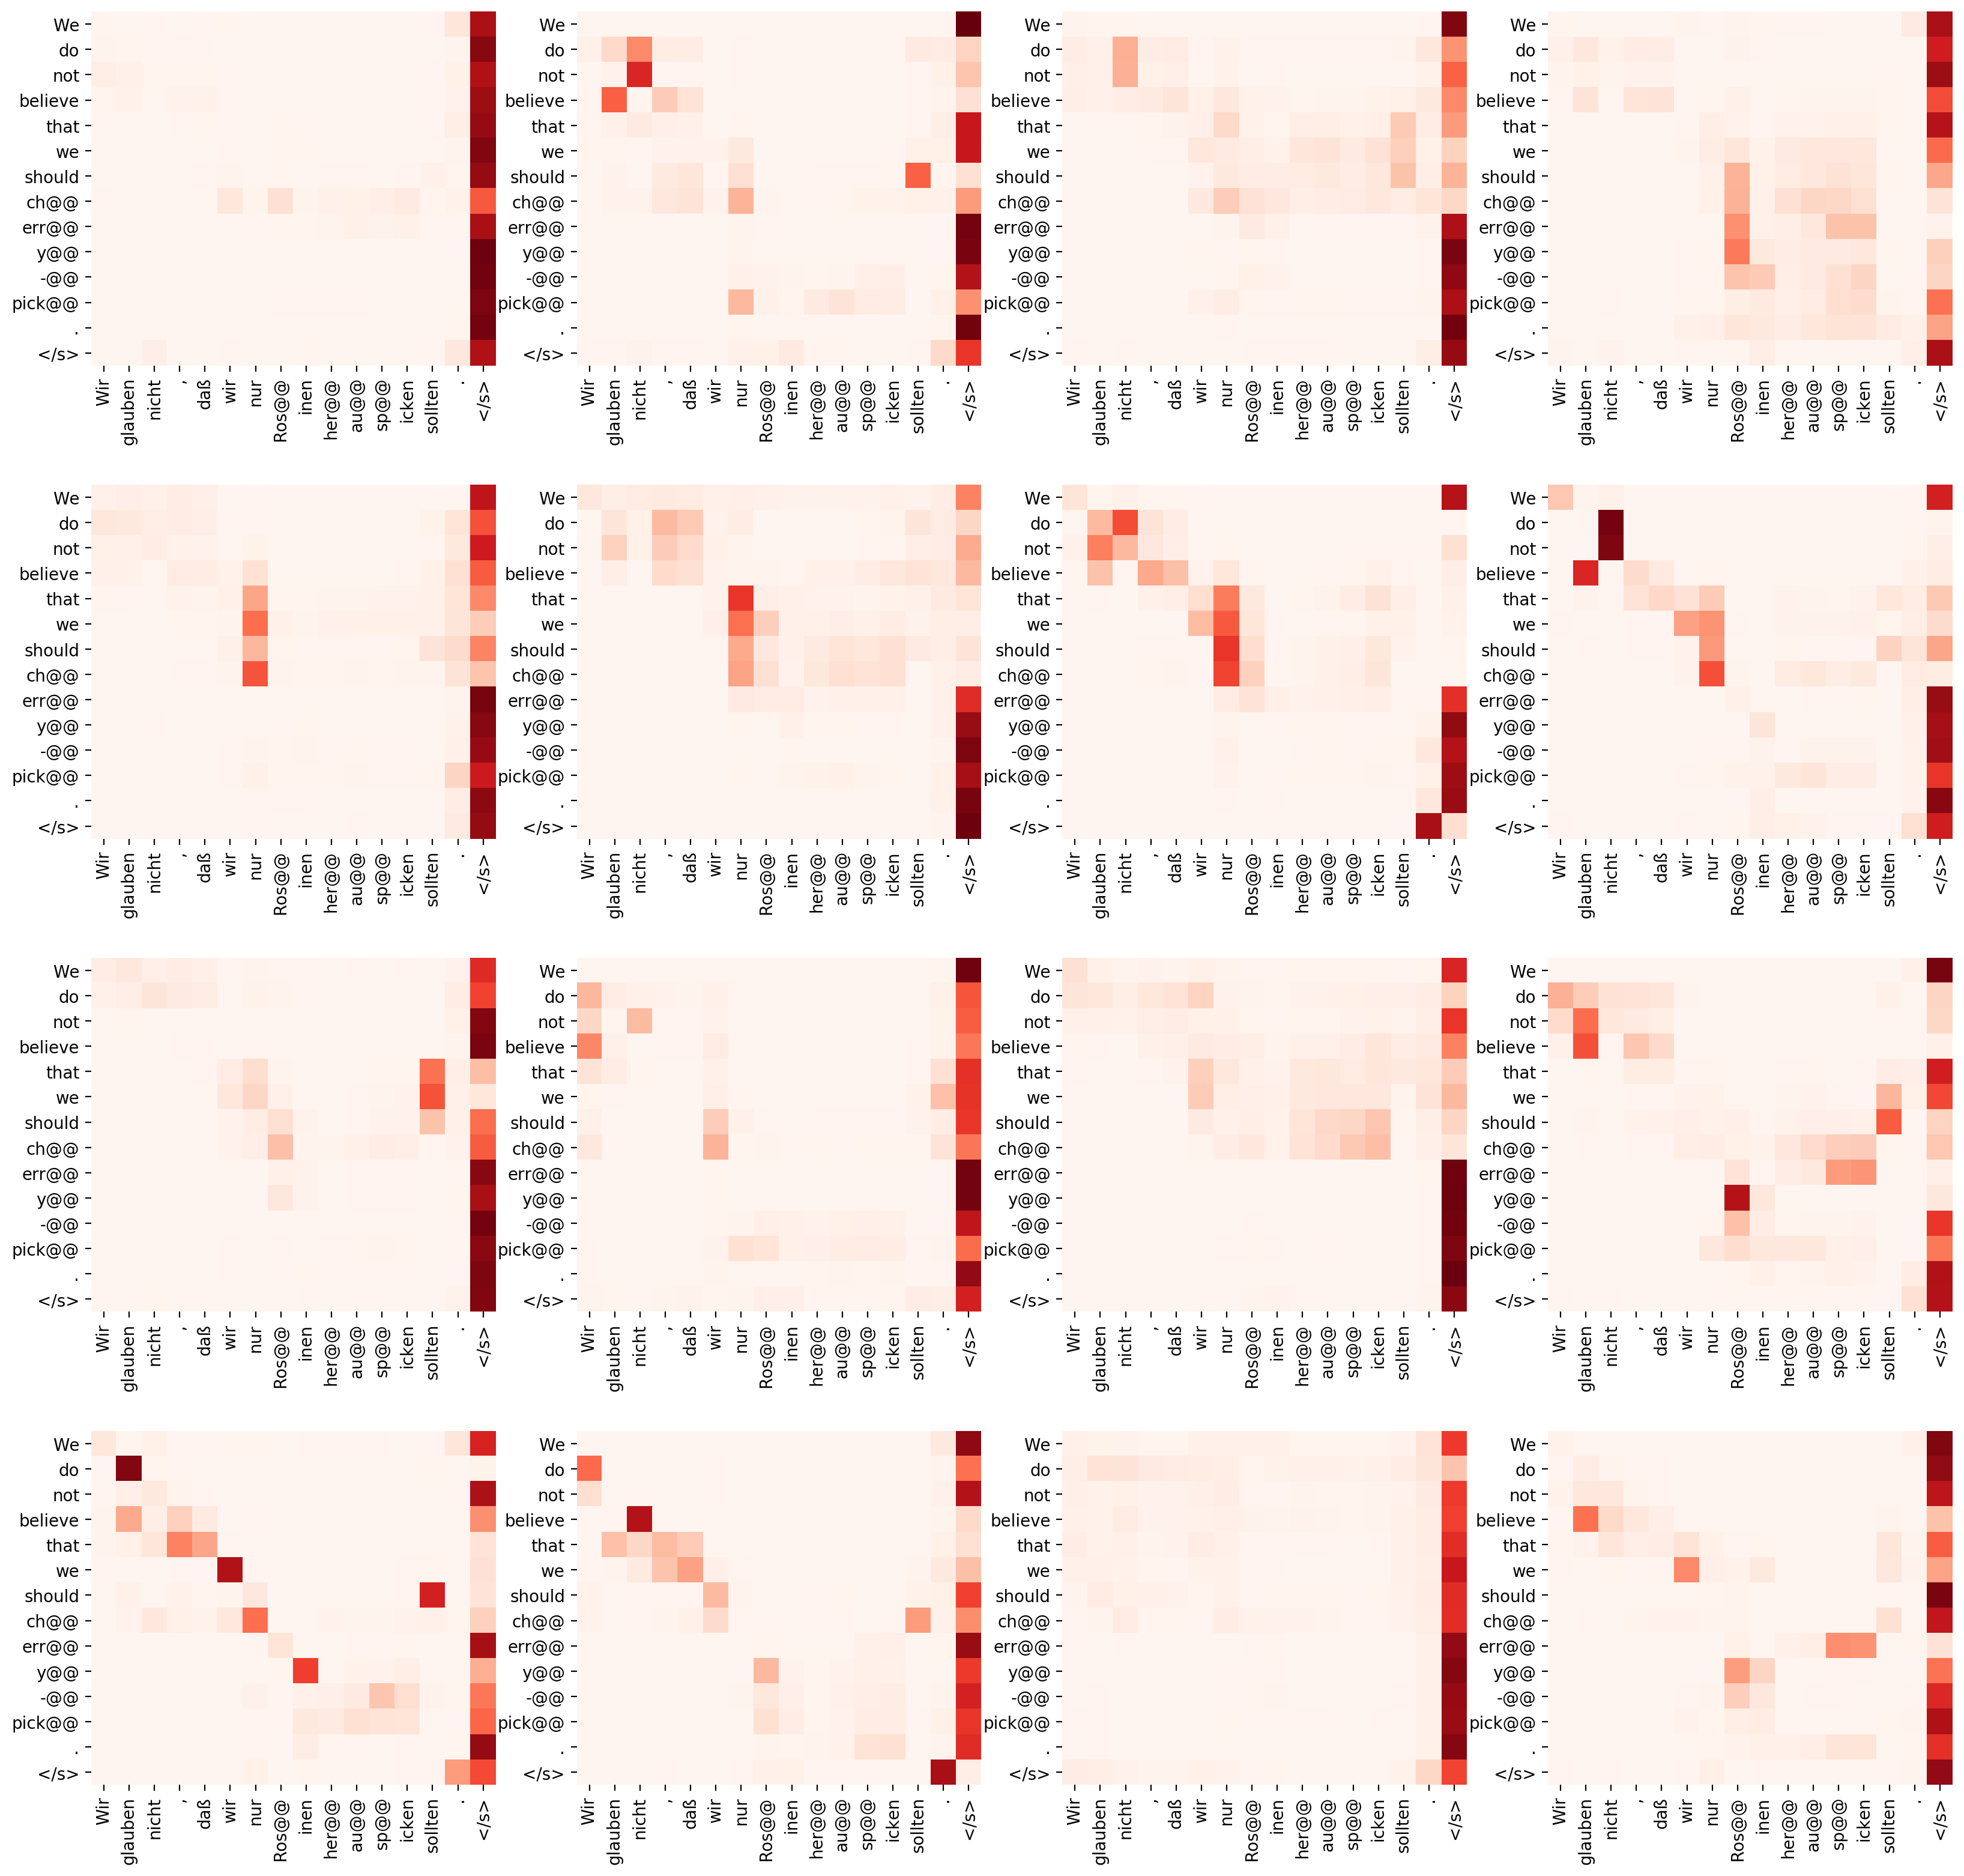


 5 layer


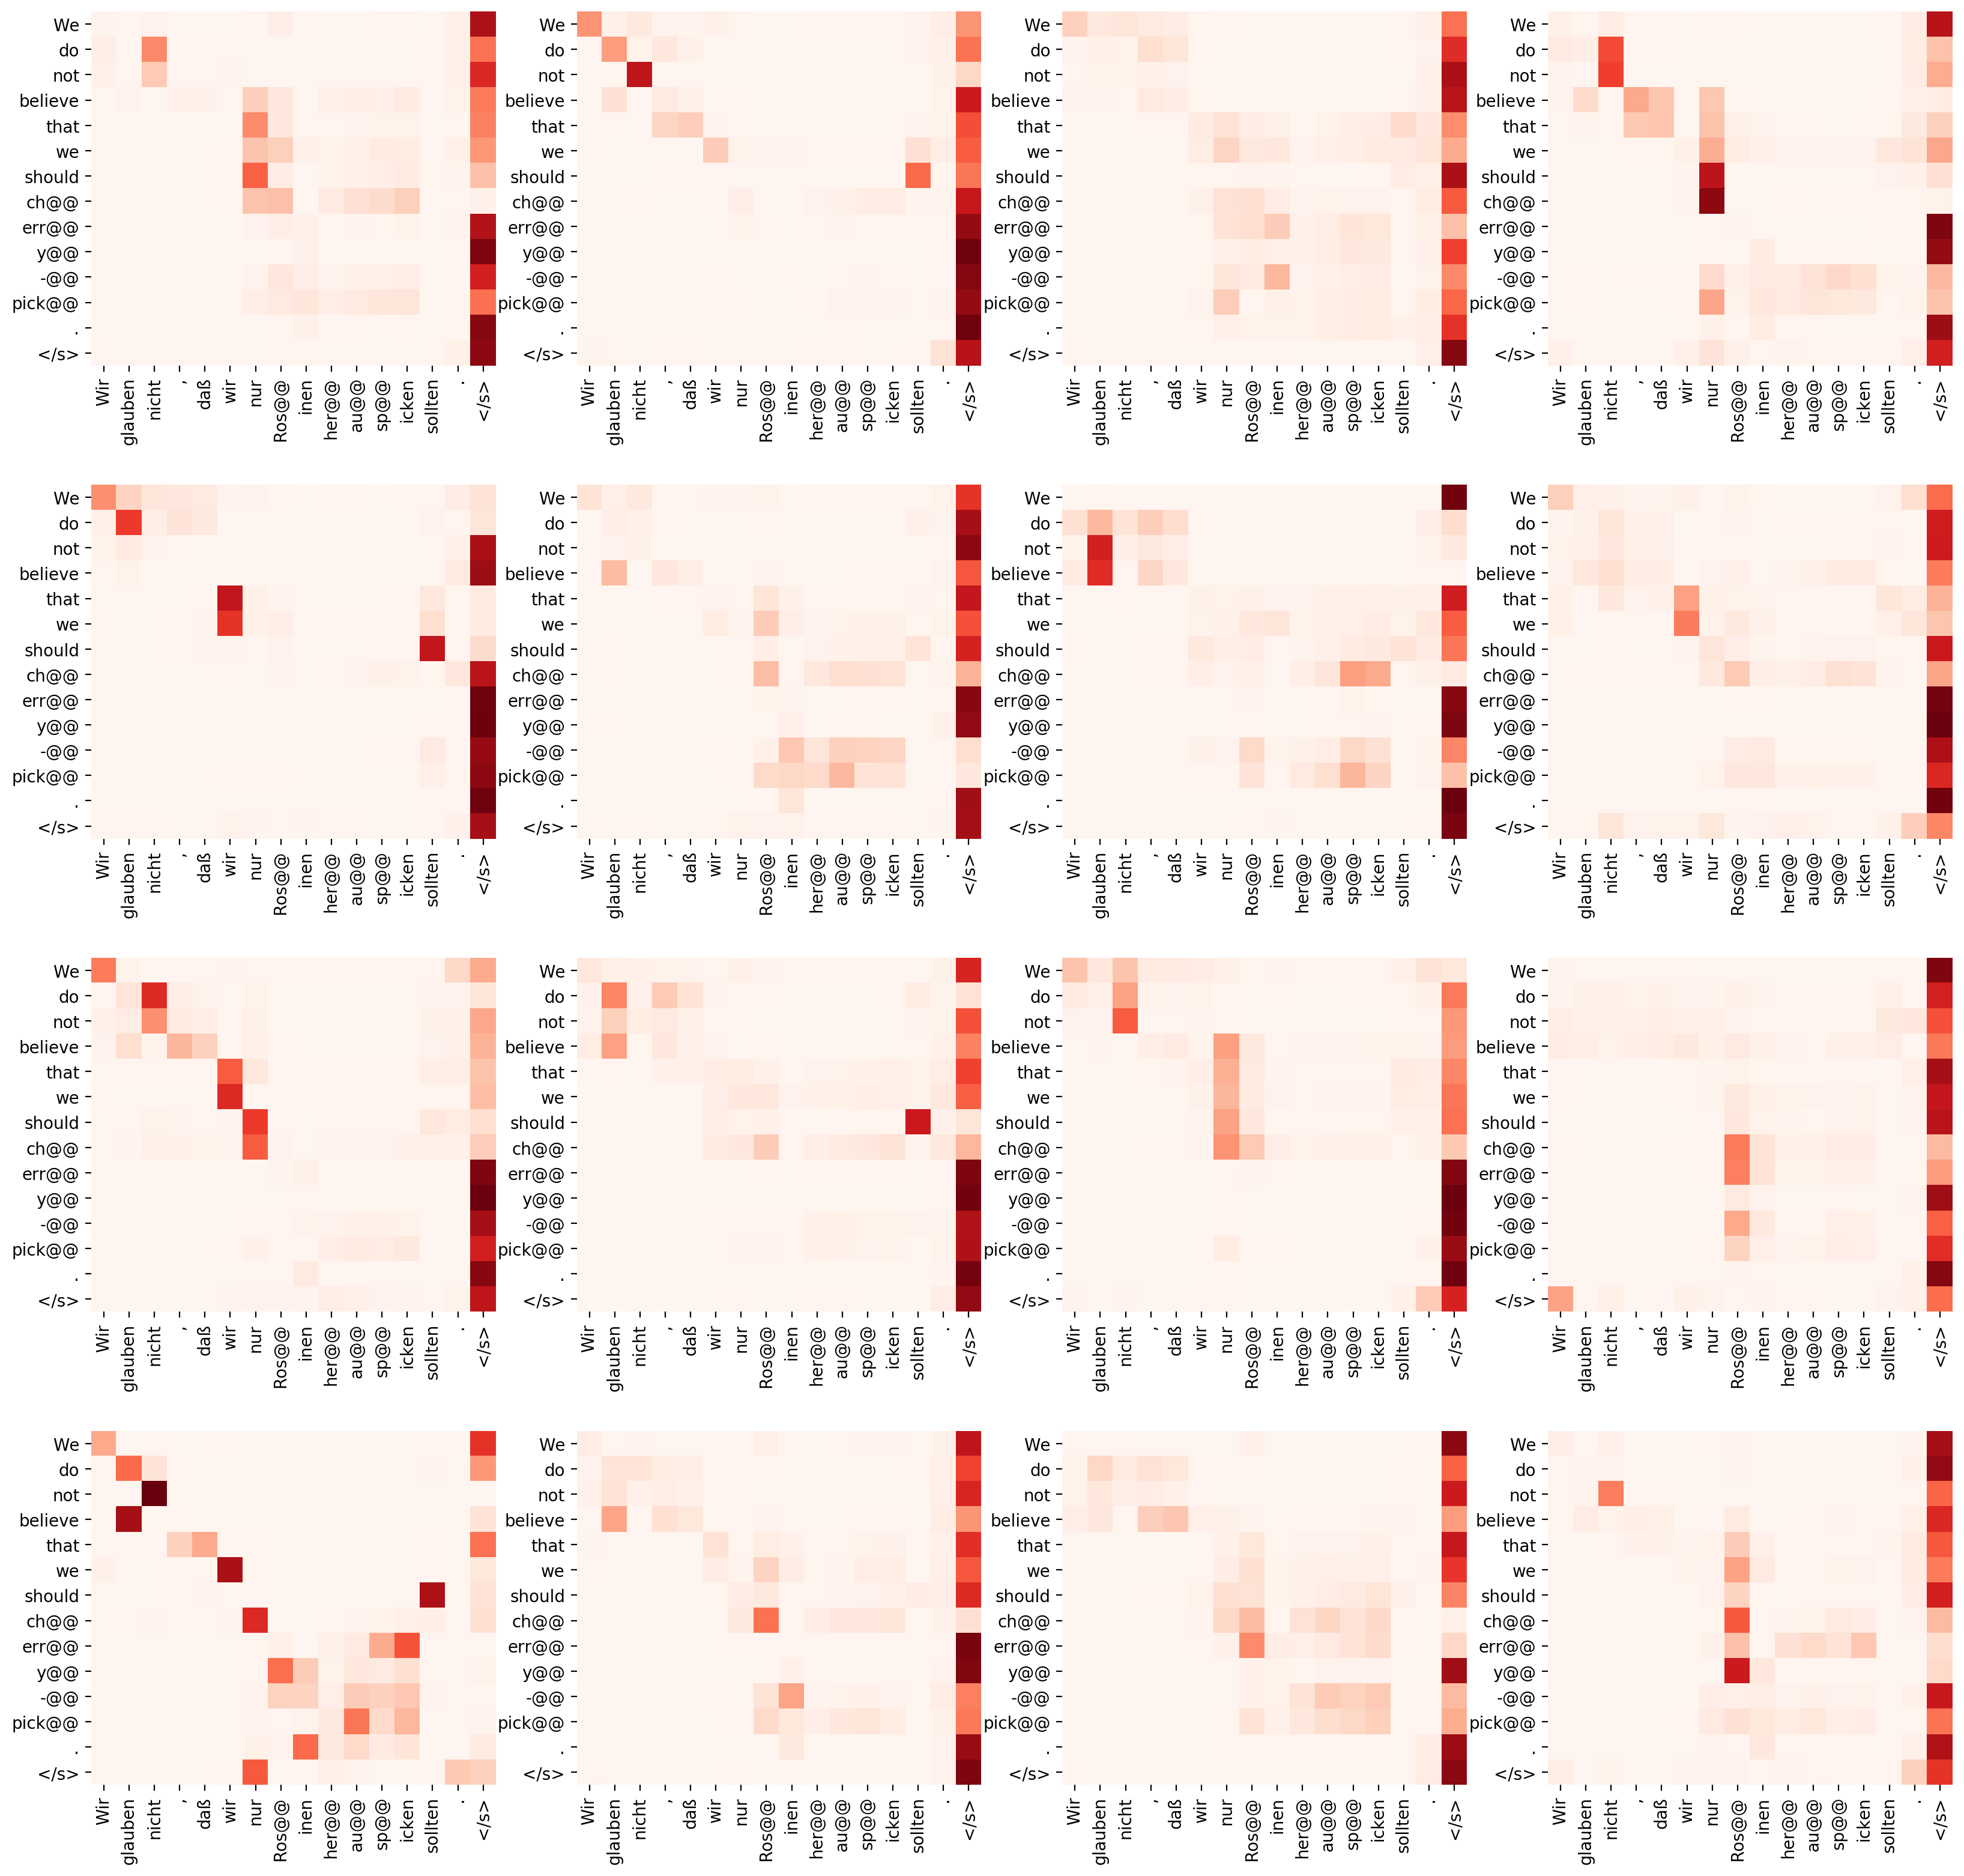


 6 layer


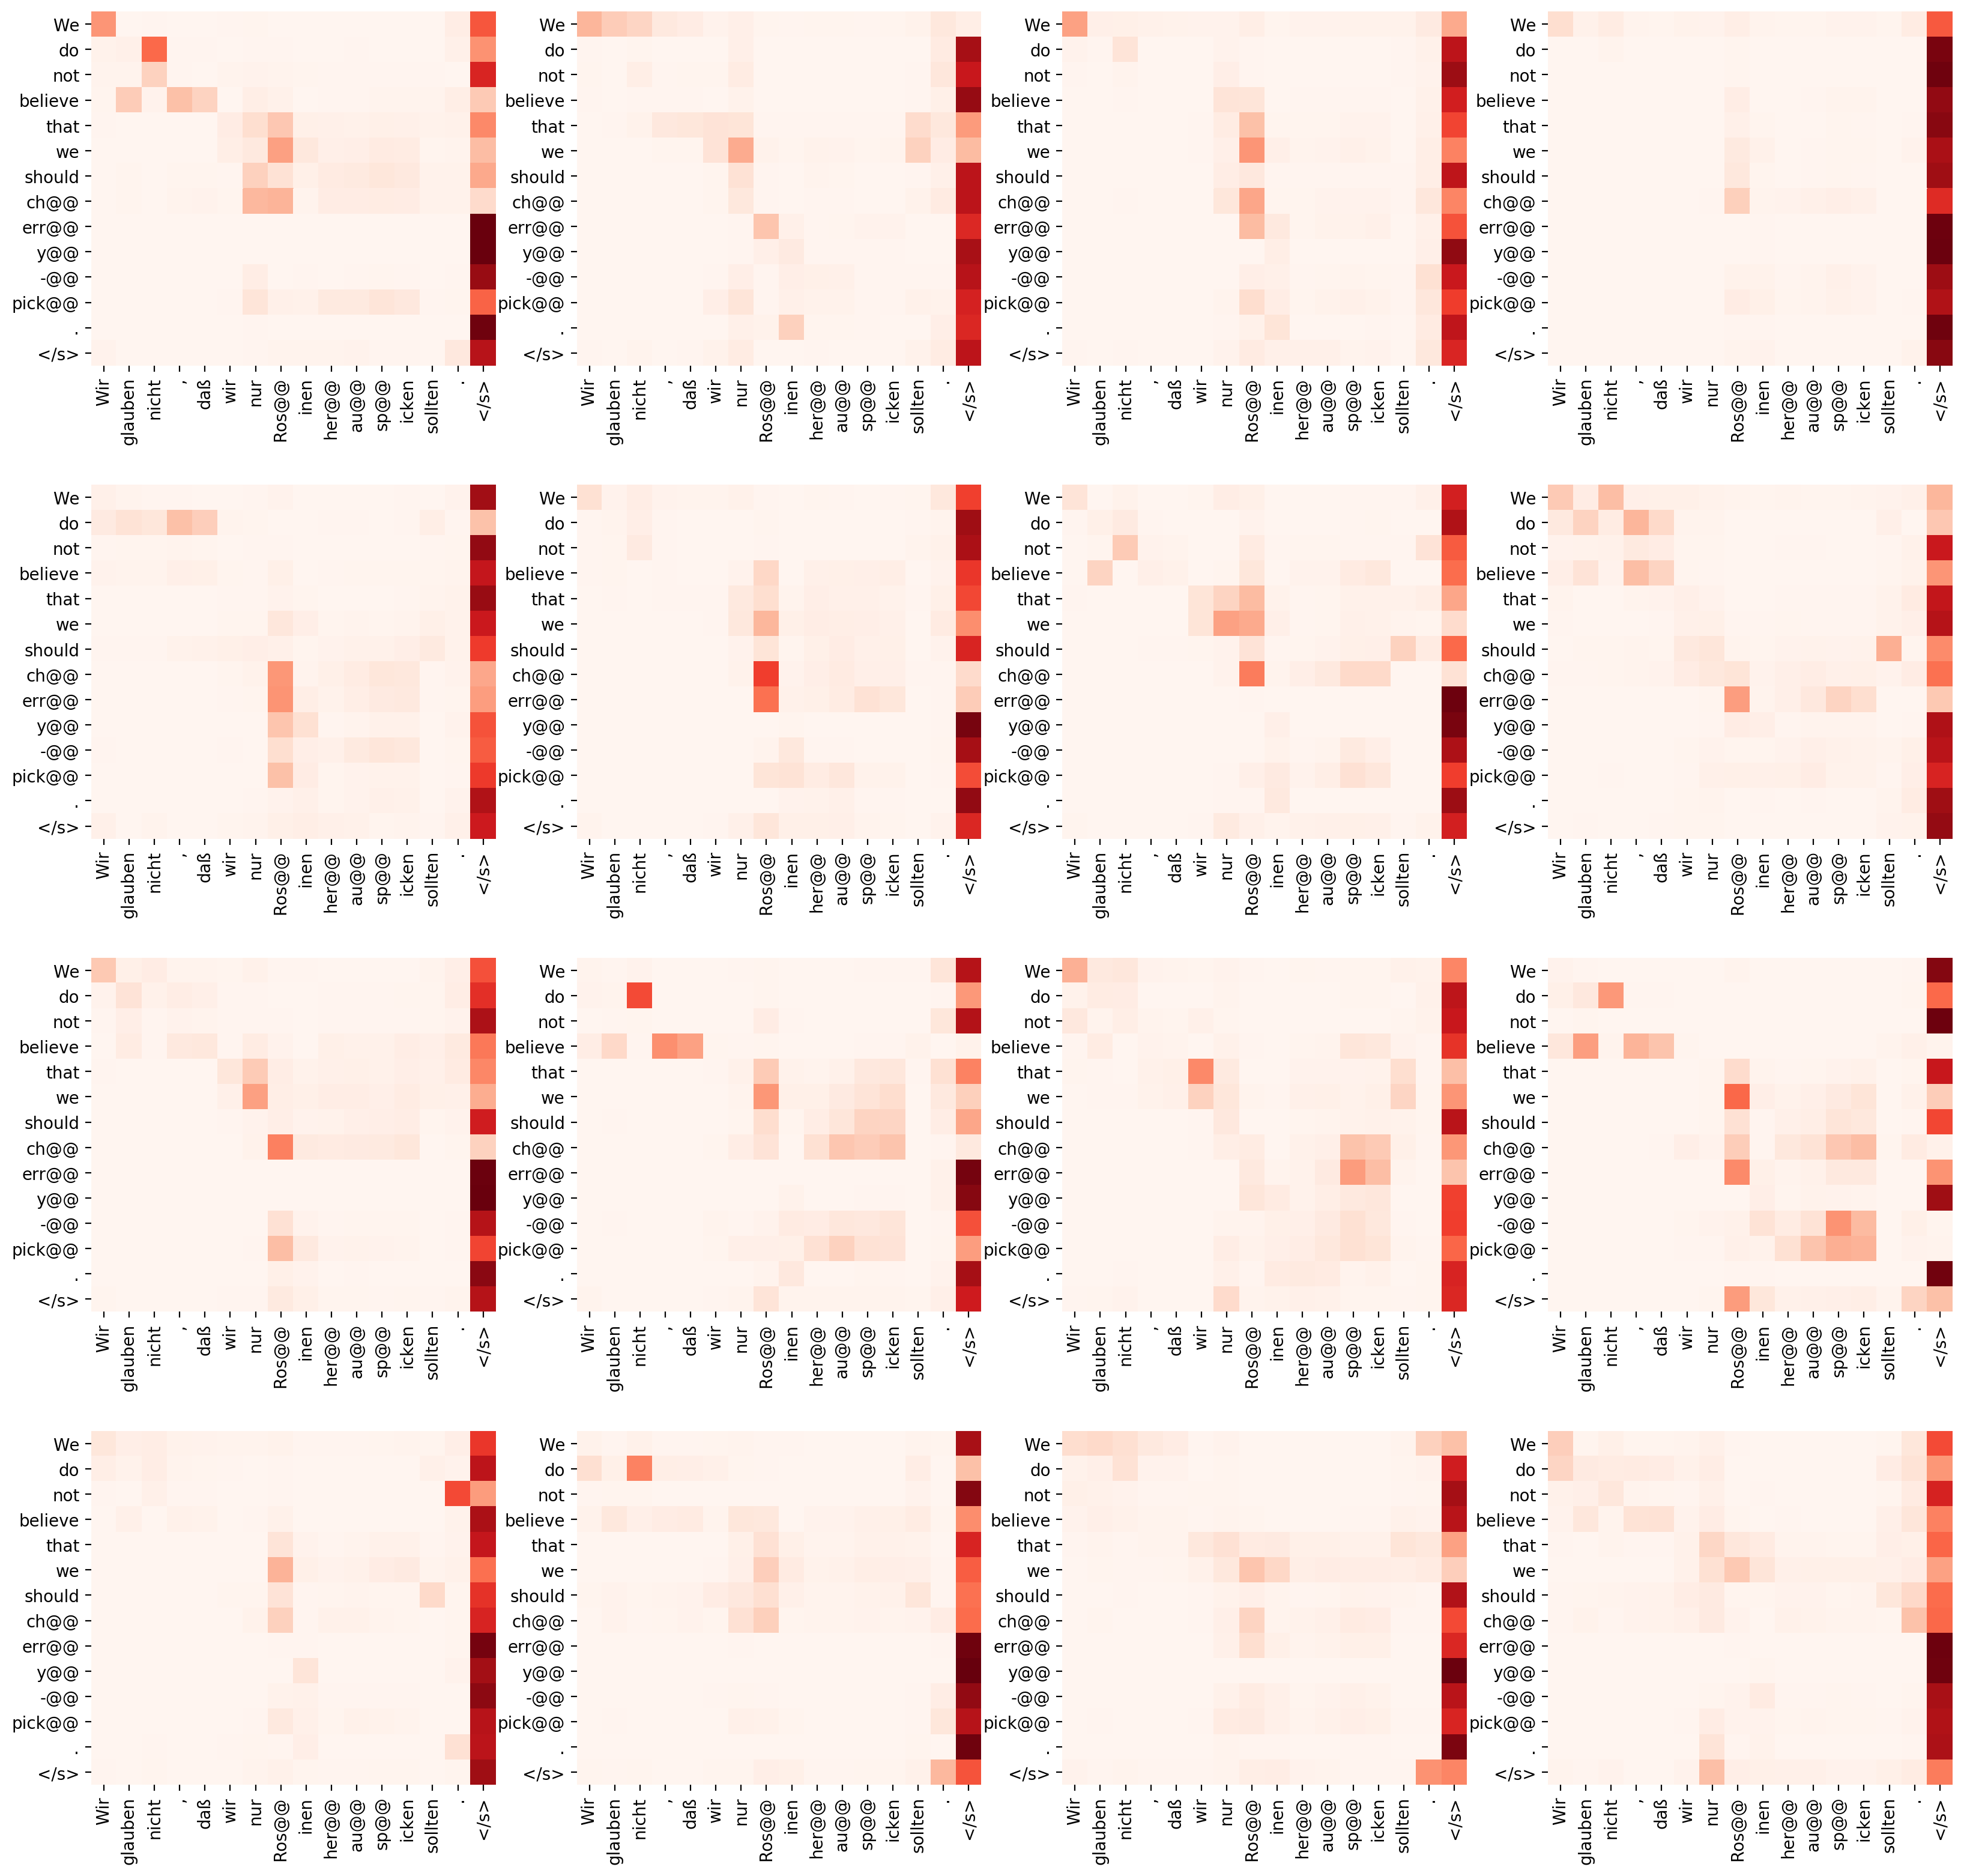

In [12]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

for layer in range(6):
    print("\n",layer+1,"layer")
    fig, axe = plt.subplots(4, 4, figsize=(20, 20), dpi=200)
    for head in range(16):
        attention = outputs[1]['attn'][layer][head,0].detach().cpu().numpy()
        df = pd.DataFrame(attention,columns=de_toks,index=en_toks[1:]+['</s>'])
        sns.heatmap(df,vmax=1,cmap="Reds",square=True,cbar=False,ax=axe[int(head/4)][head - int(head/4)*4])
    plt.show()    

#### norm of weighted vector $||αf(x)||$


 1 layer


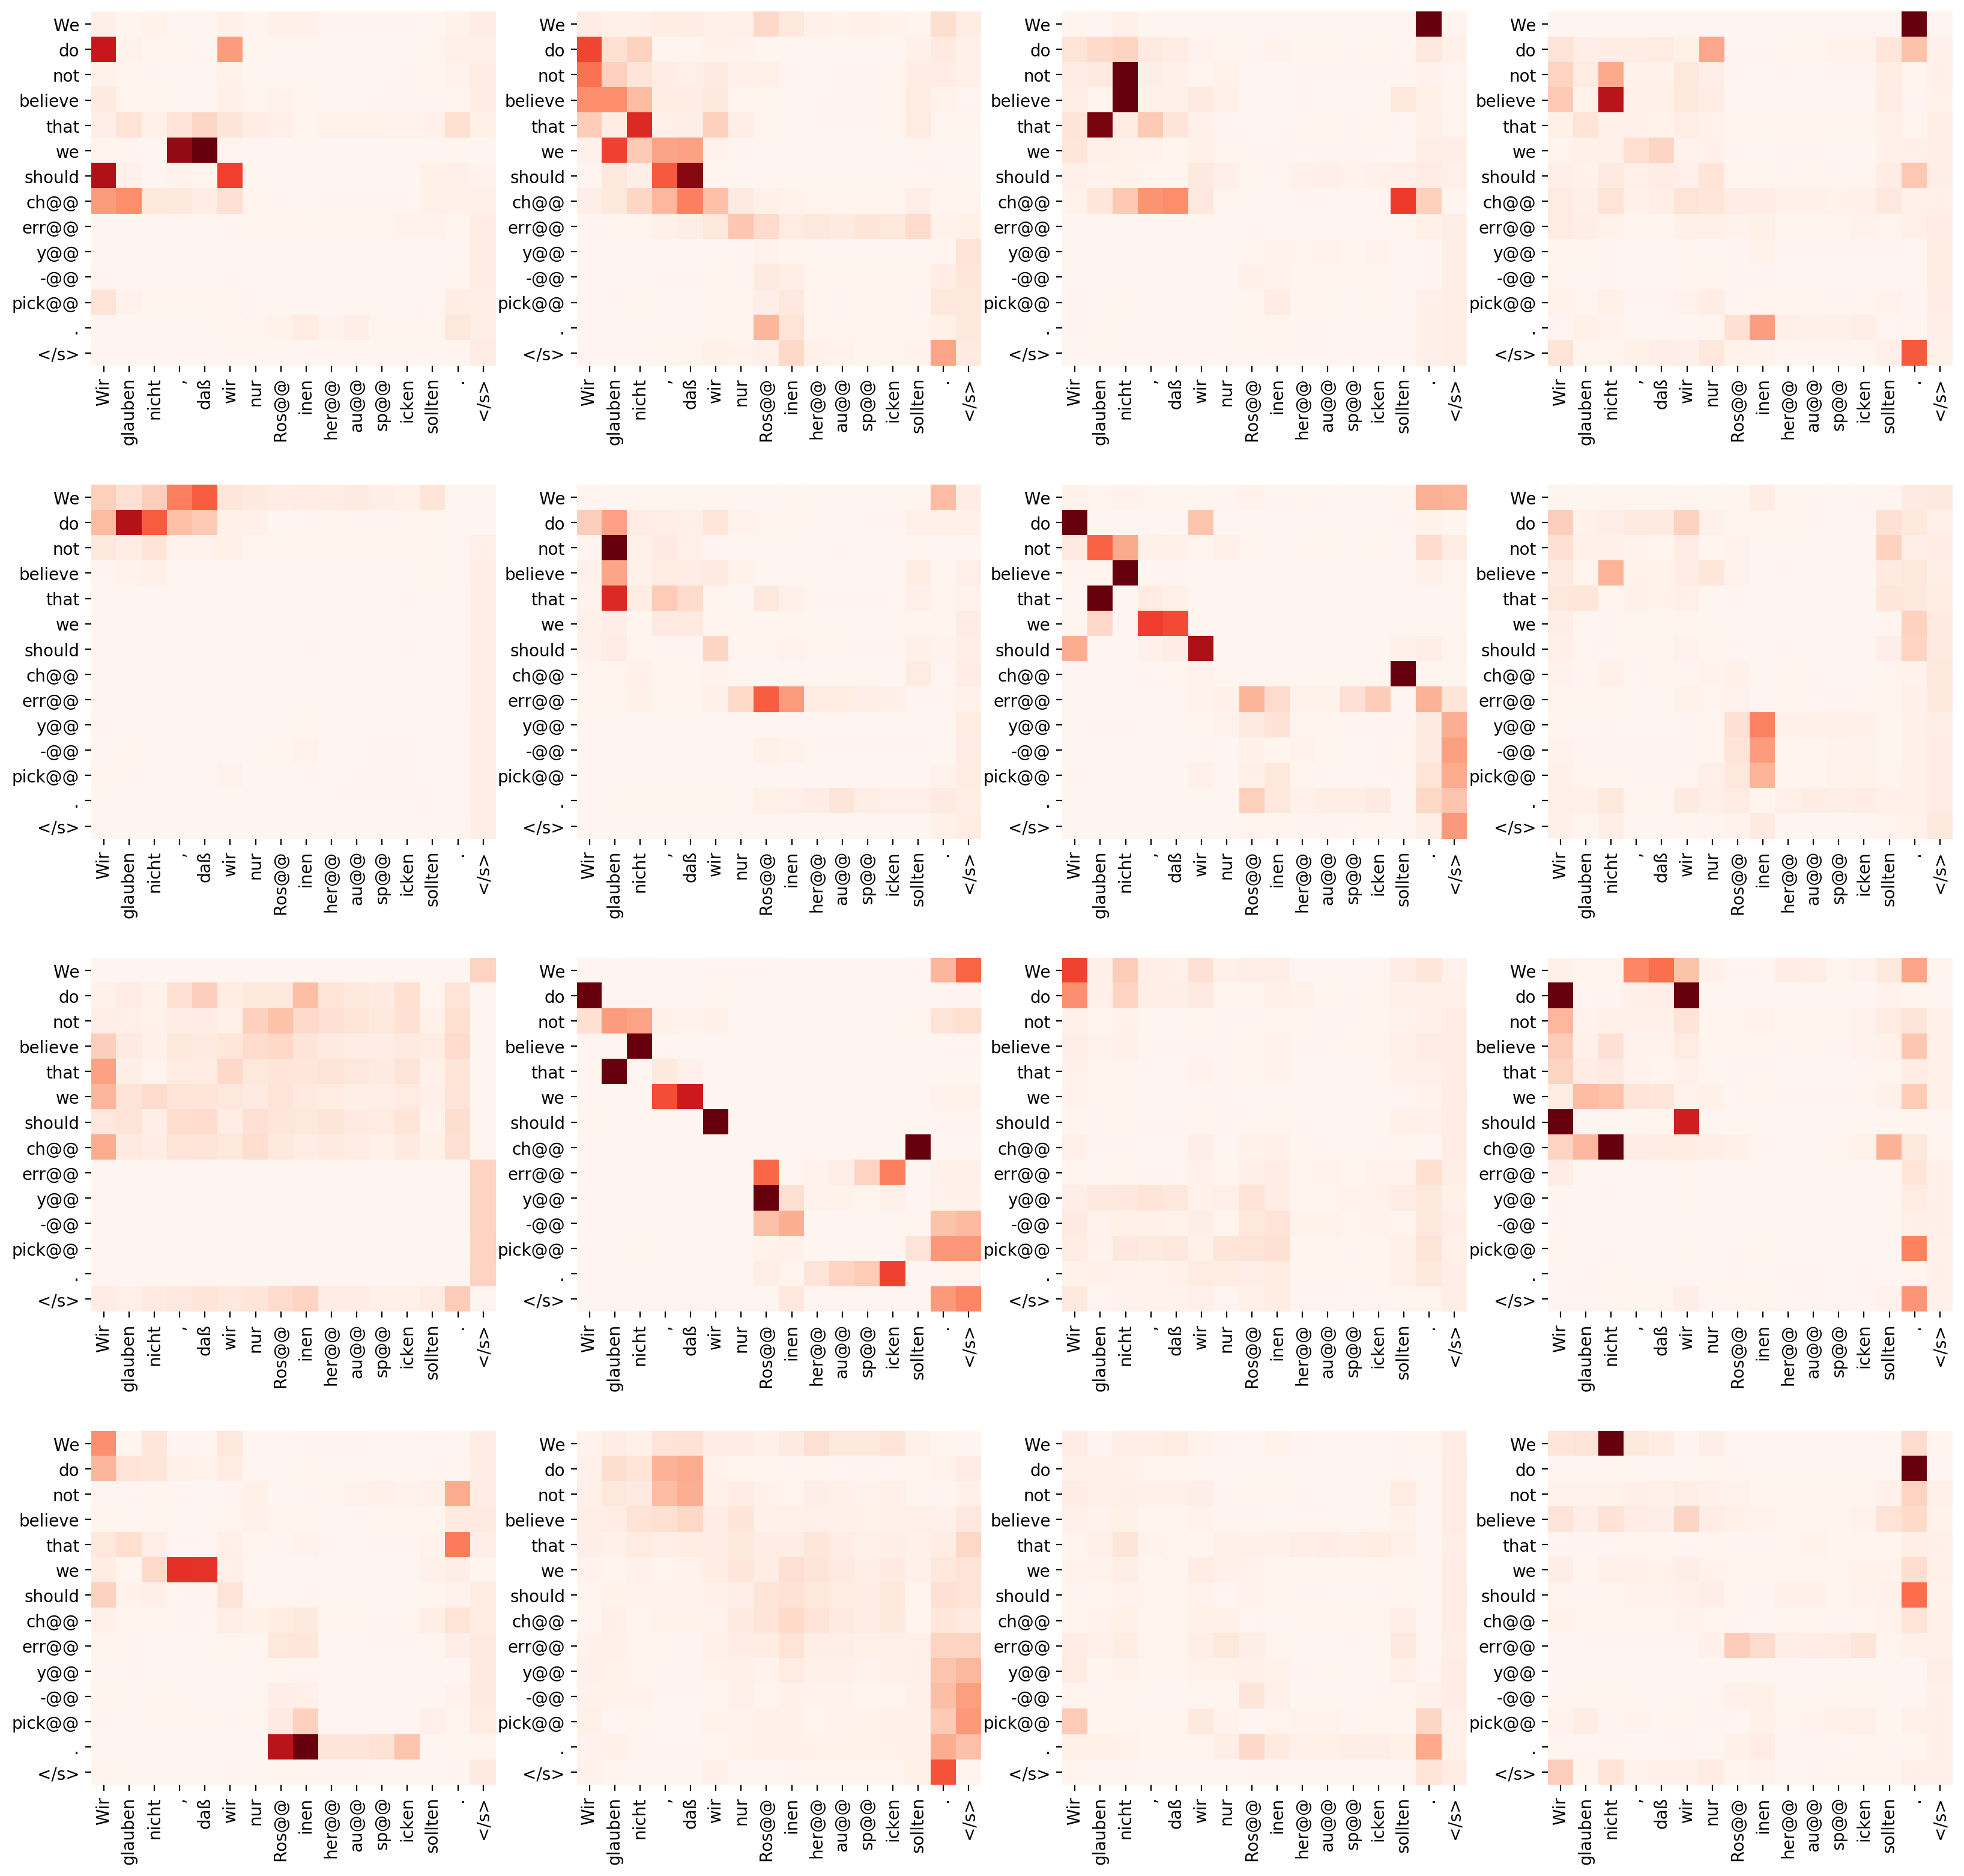


 2 layer


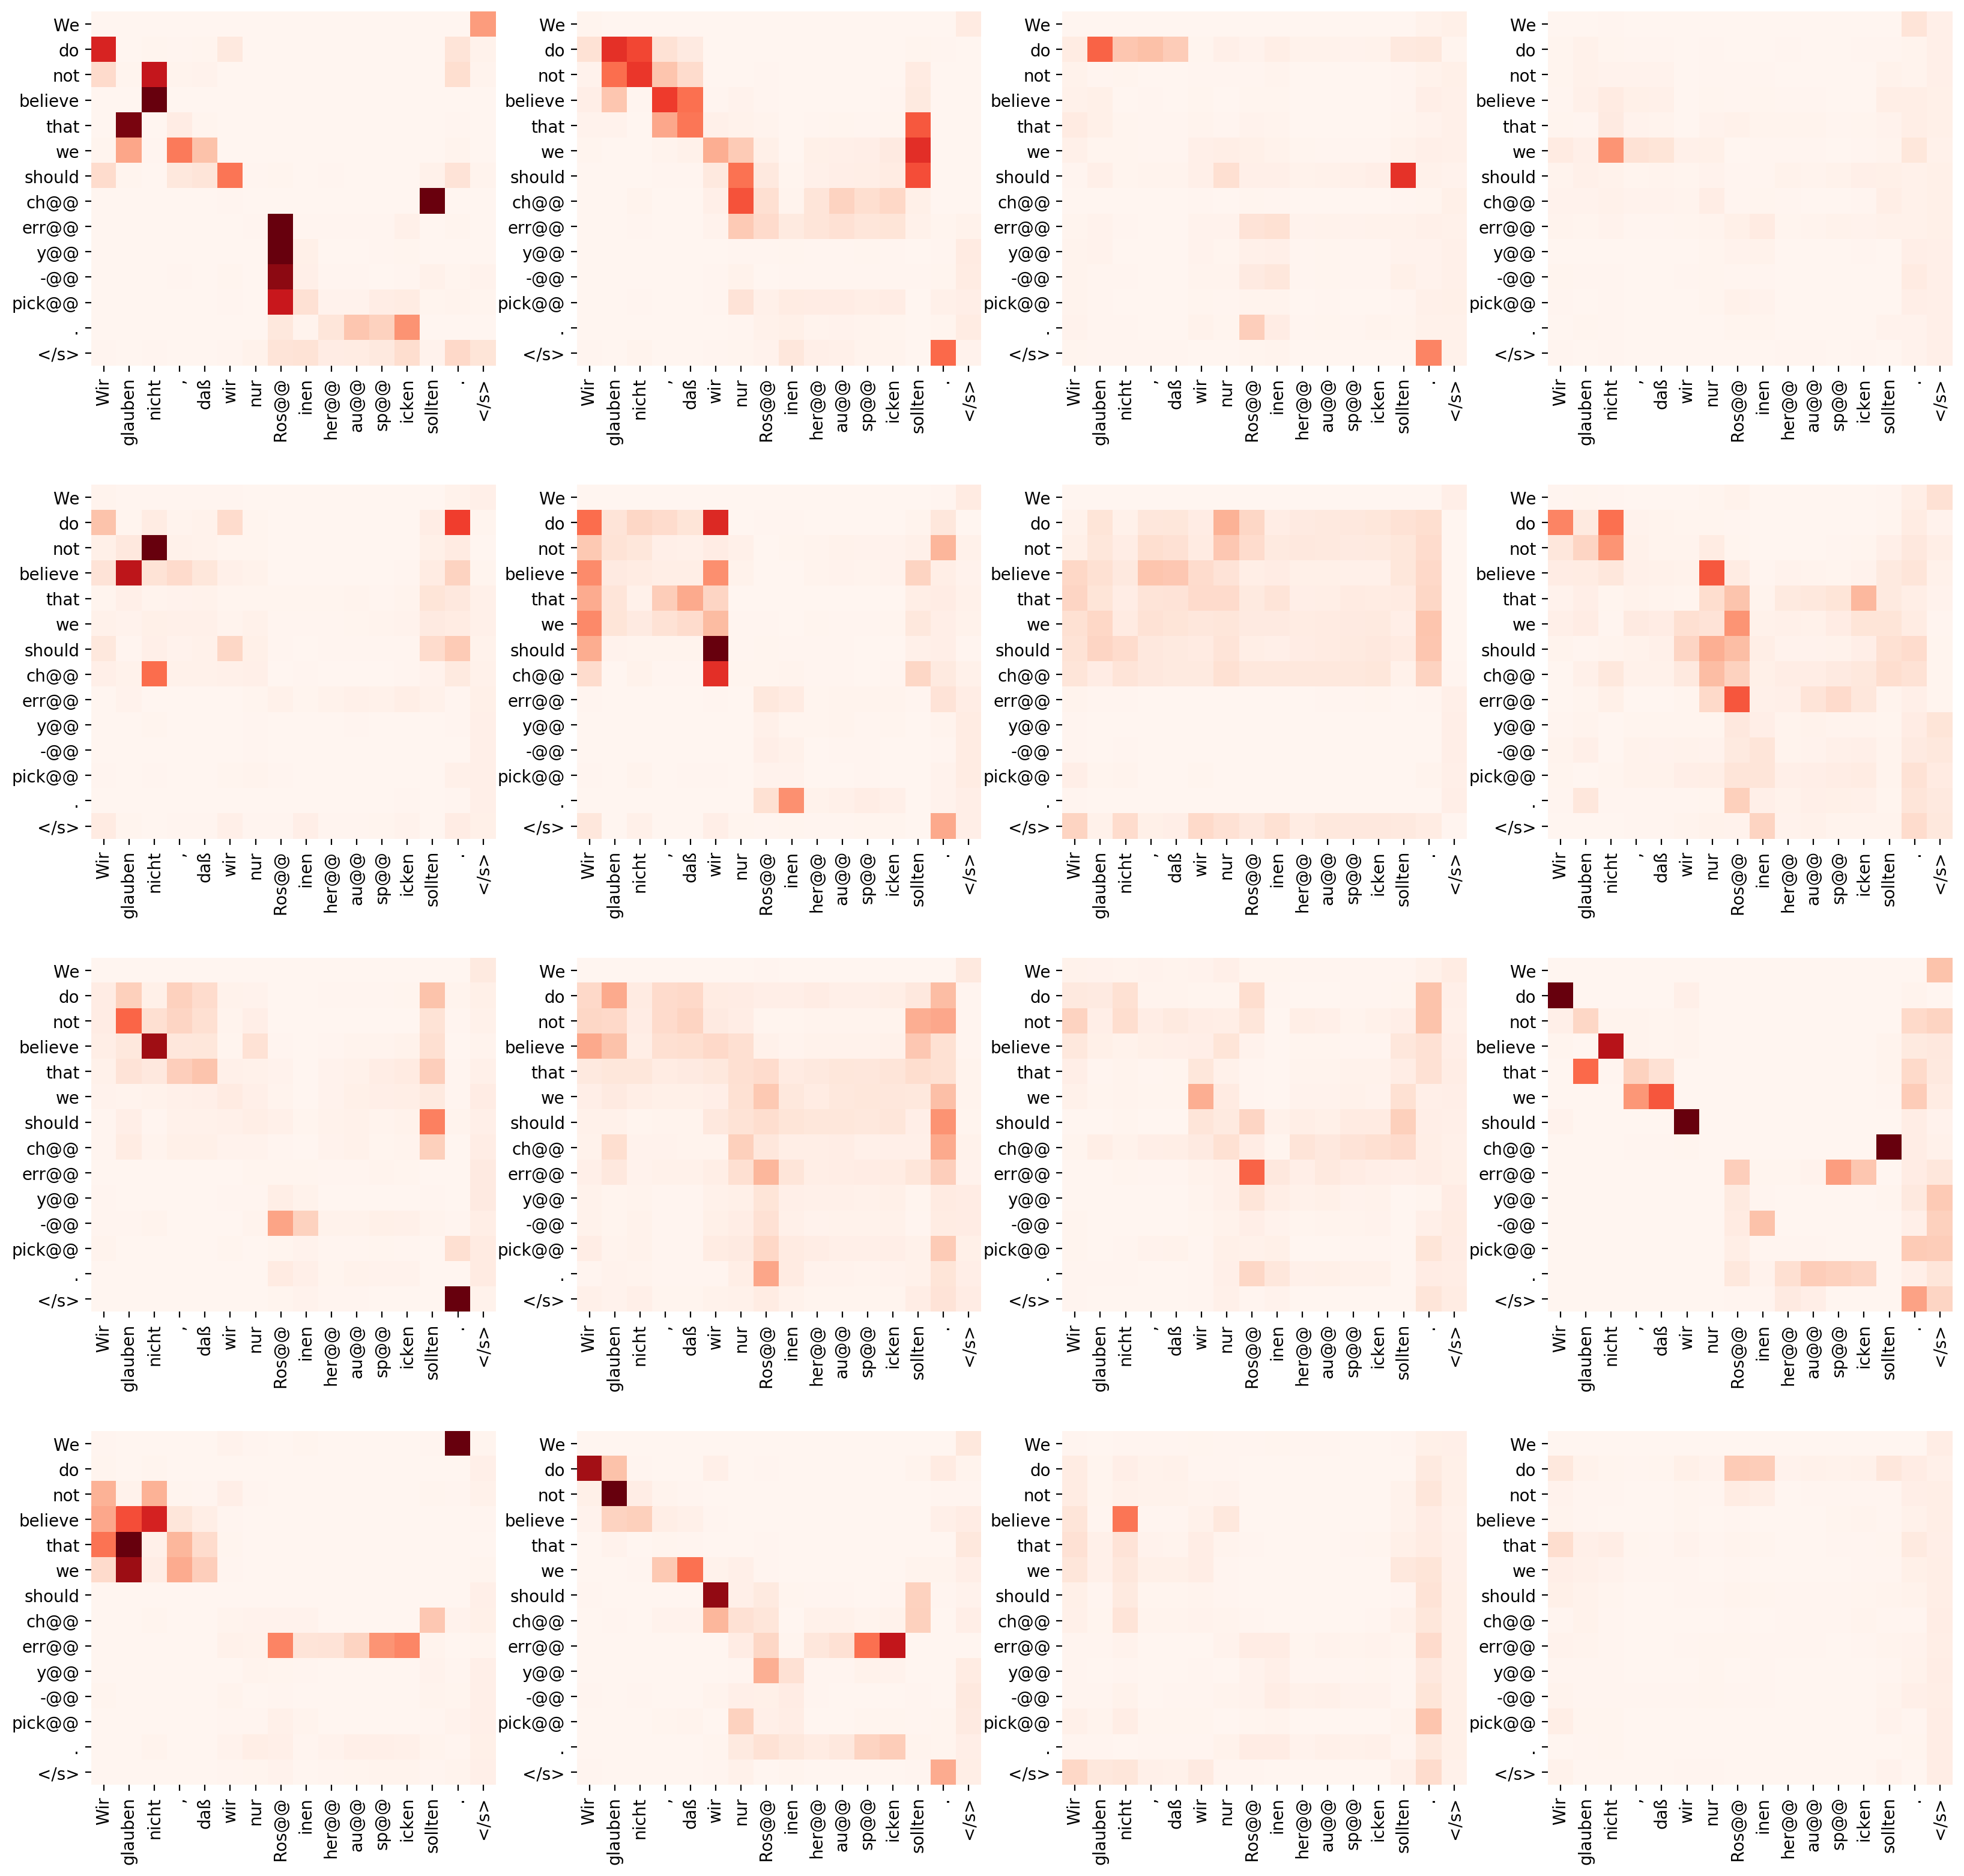


 3 layer


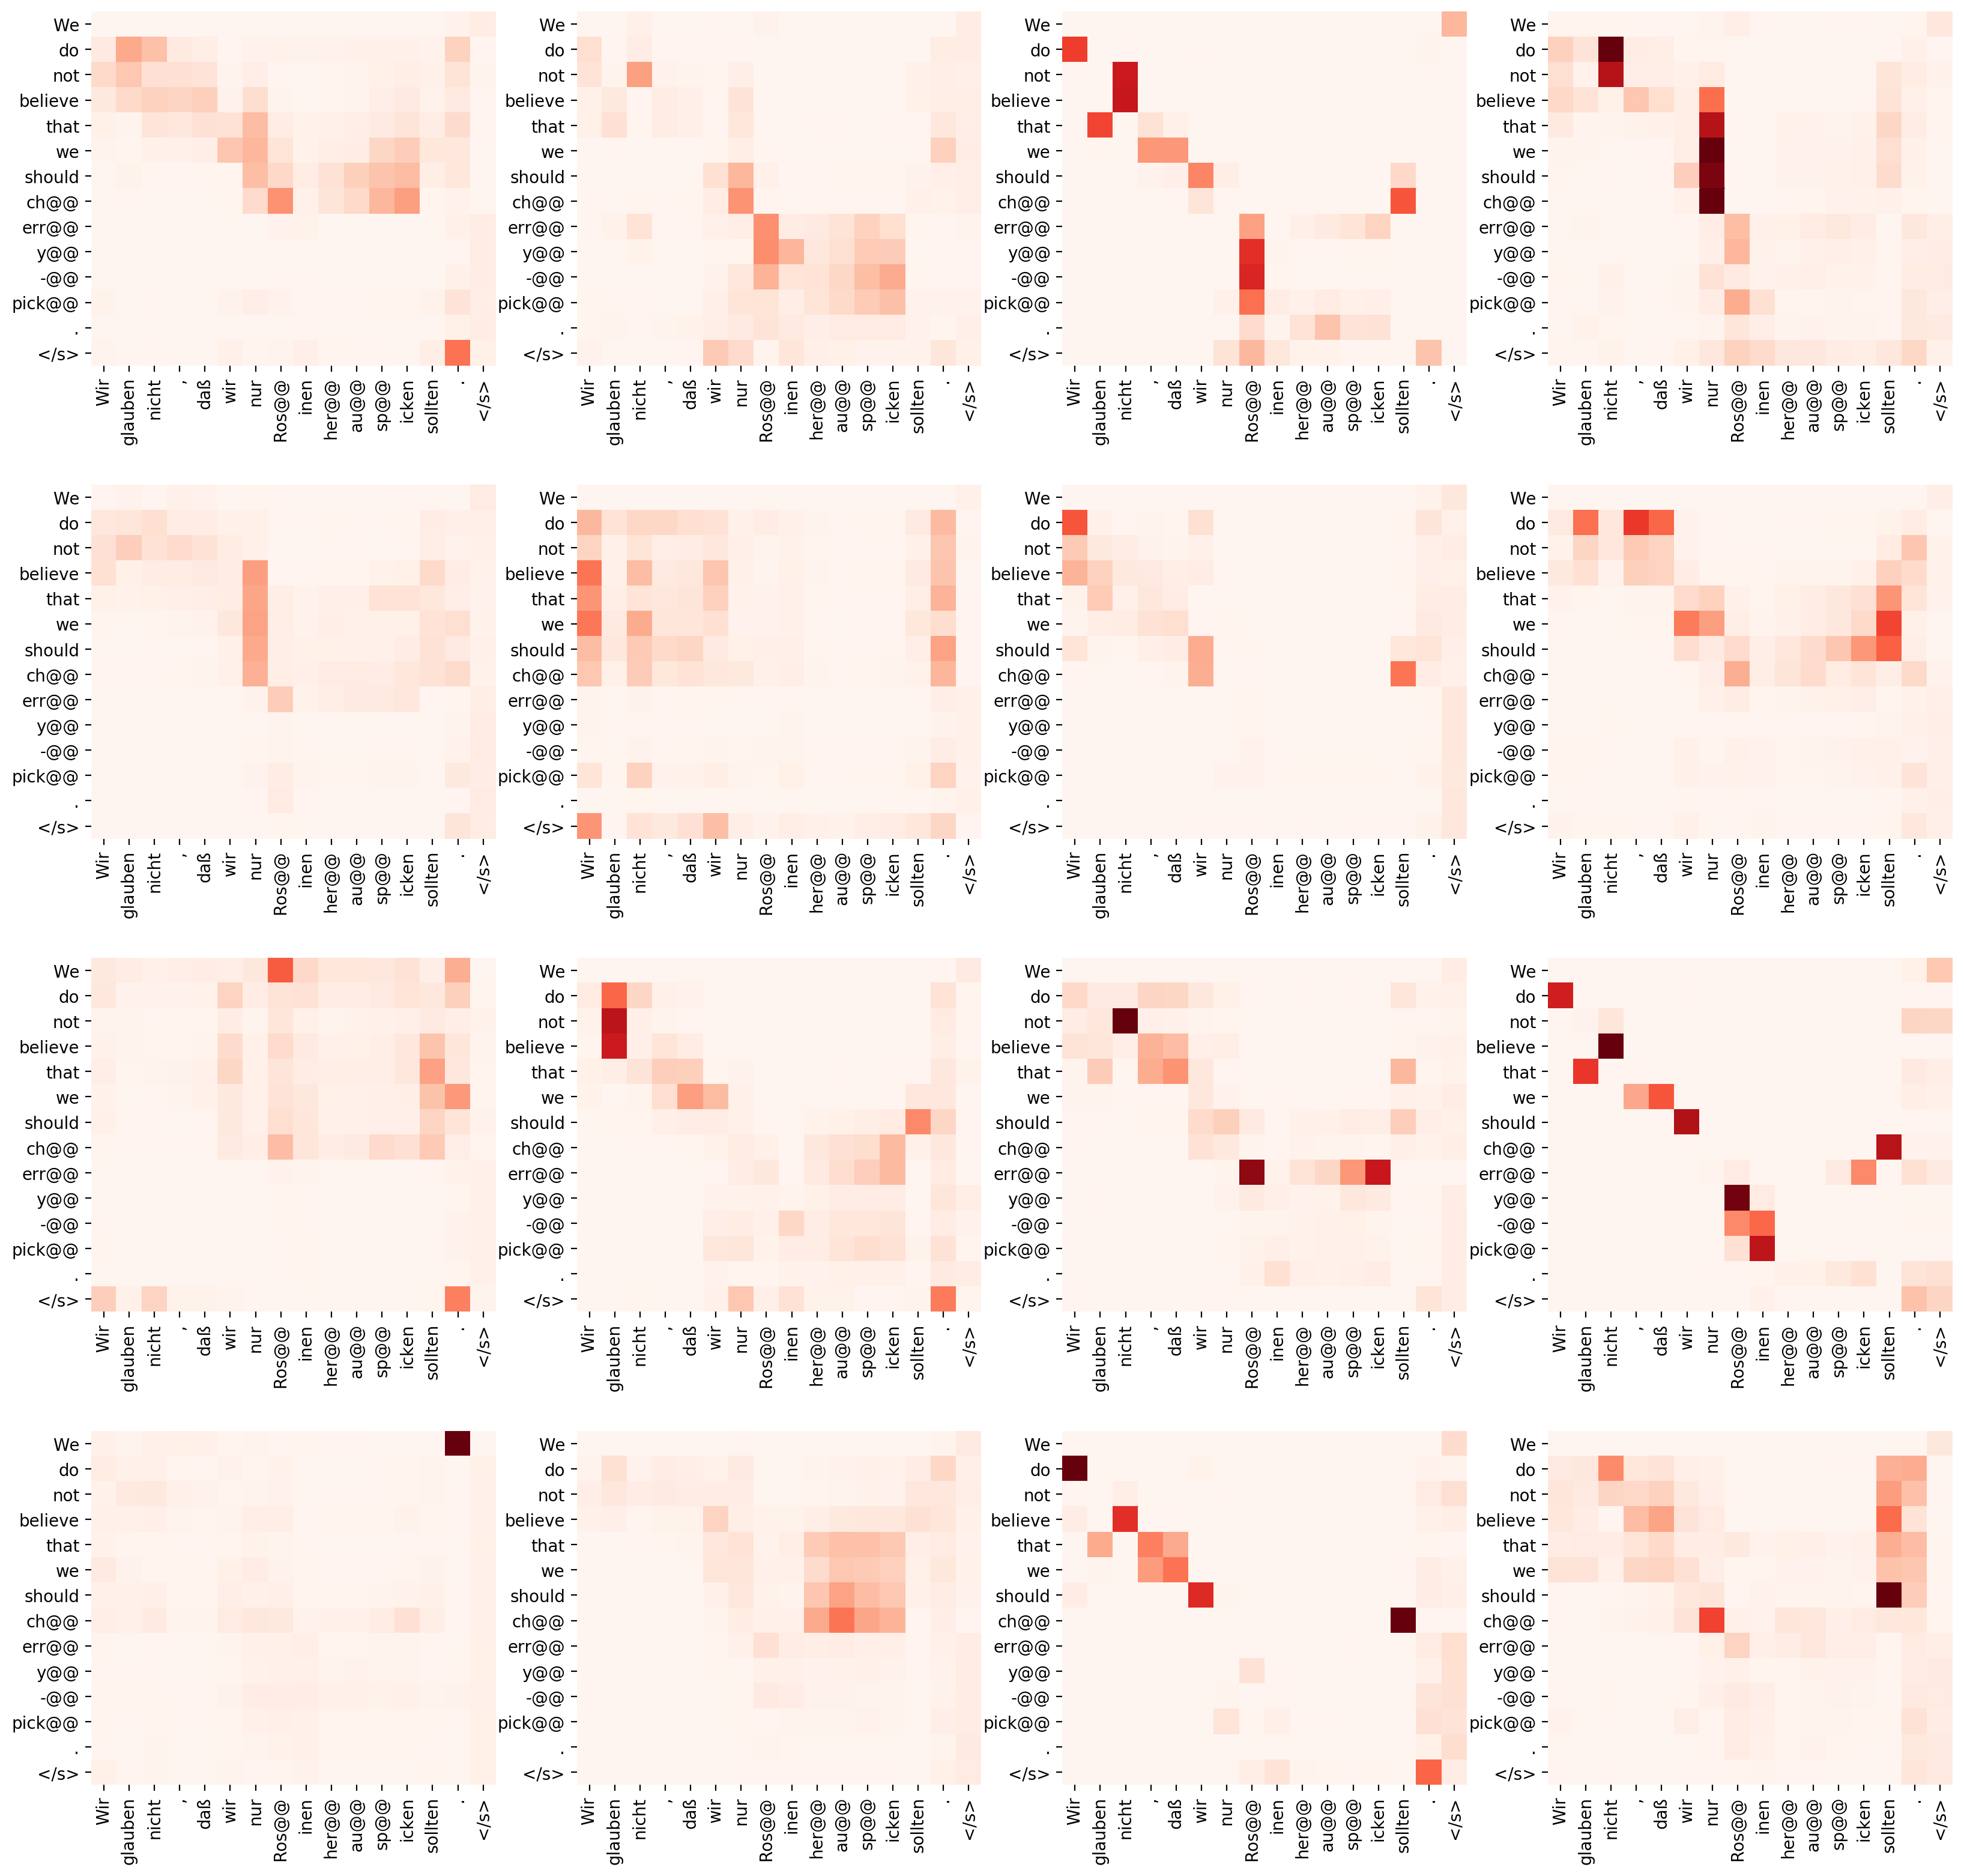


 4 layer


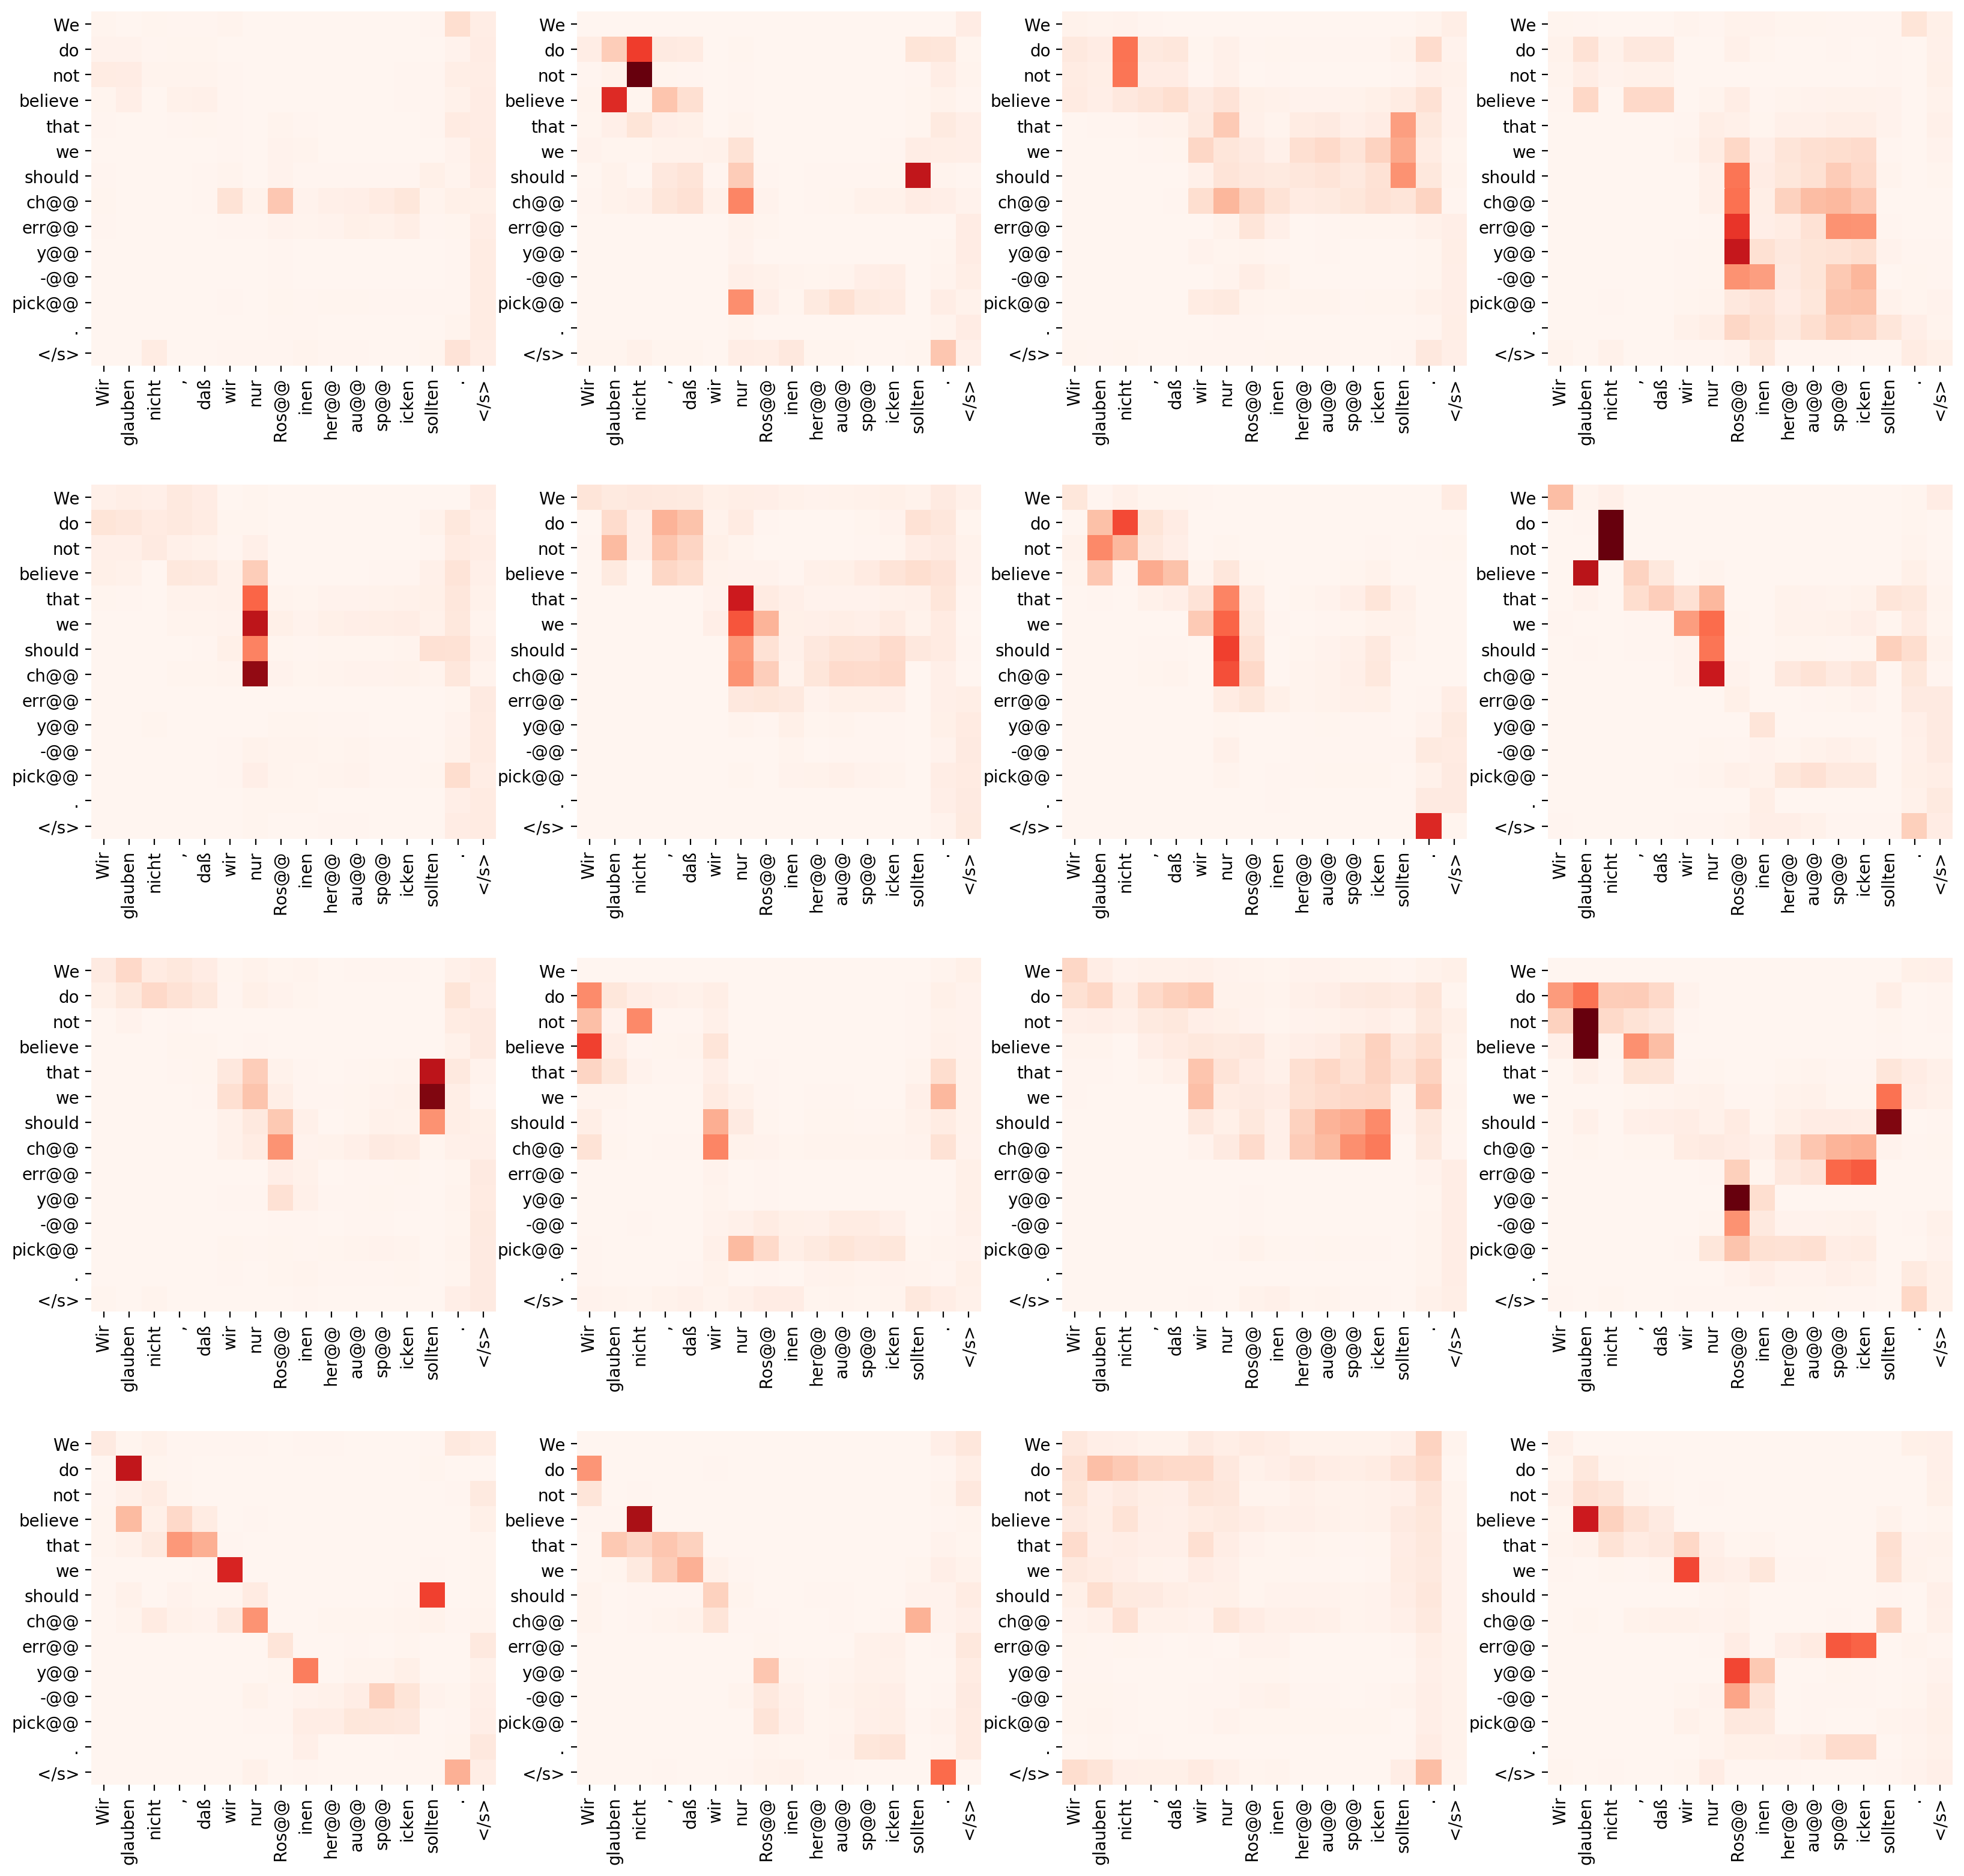


 5 layer


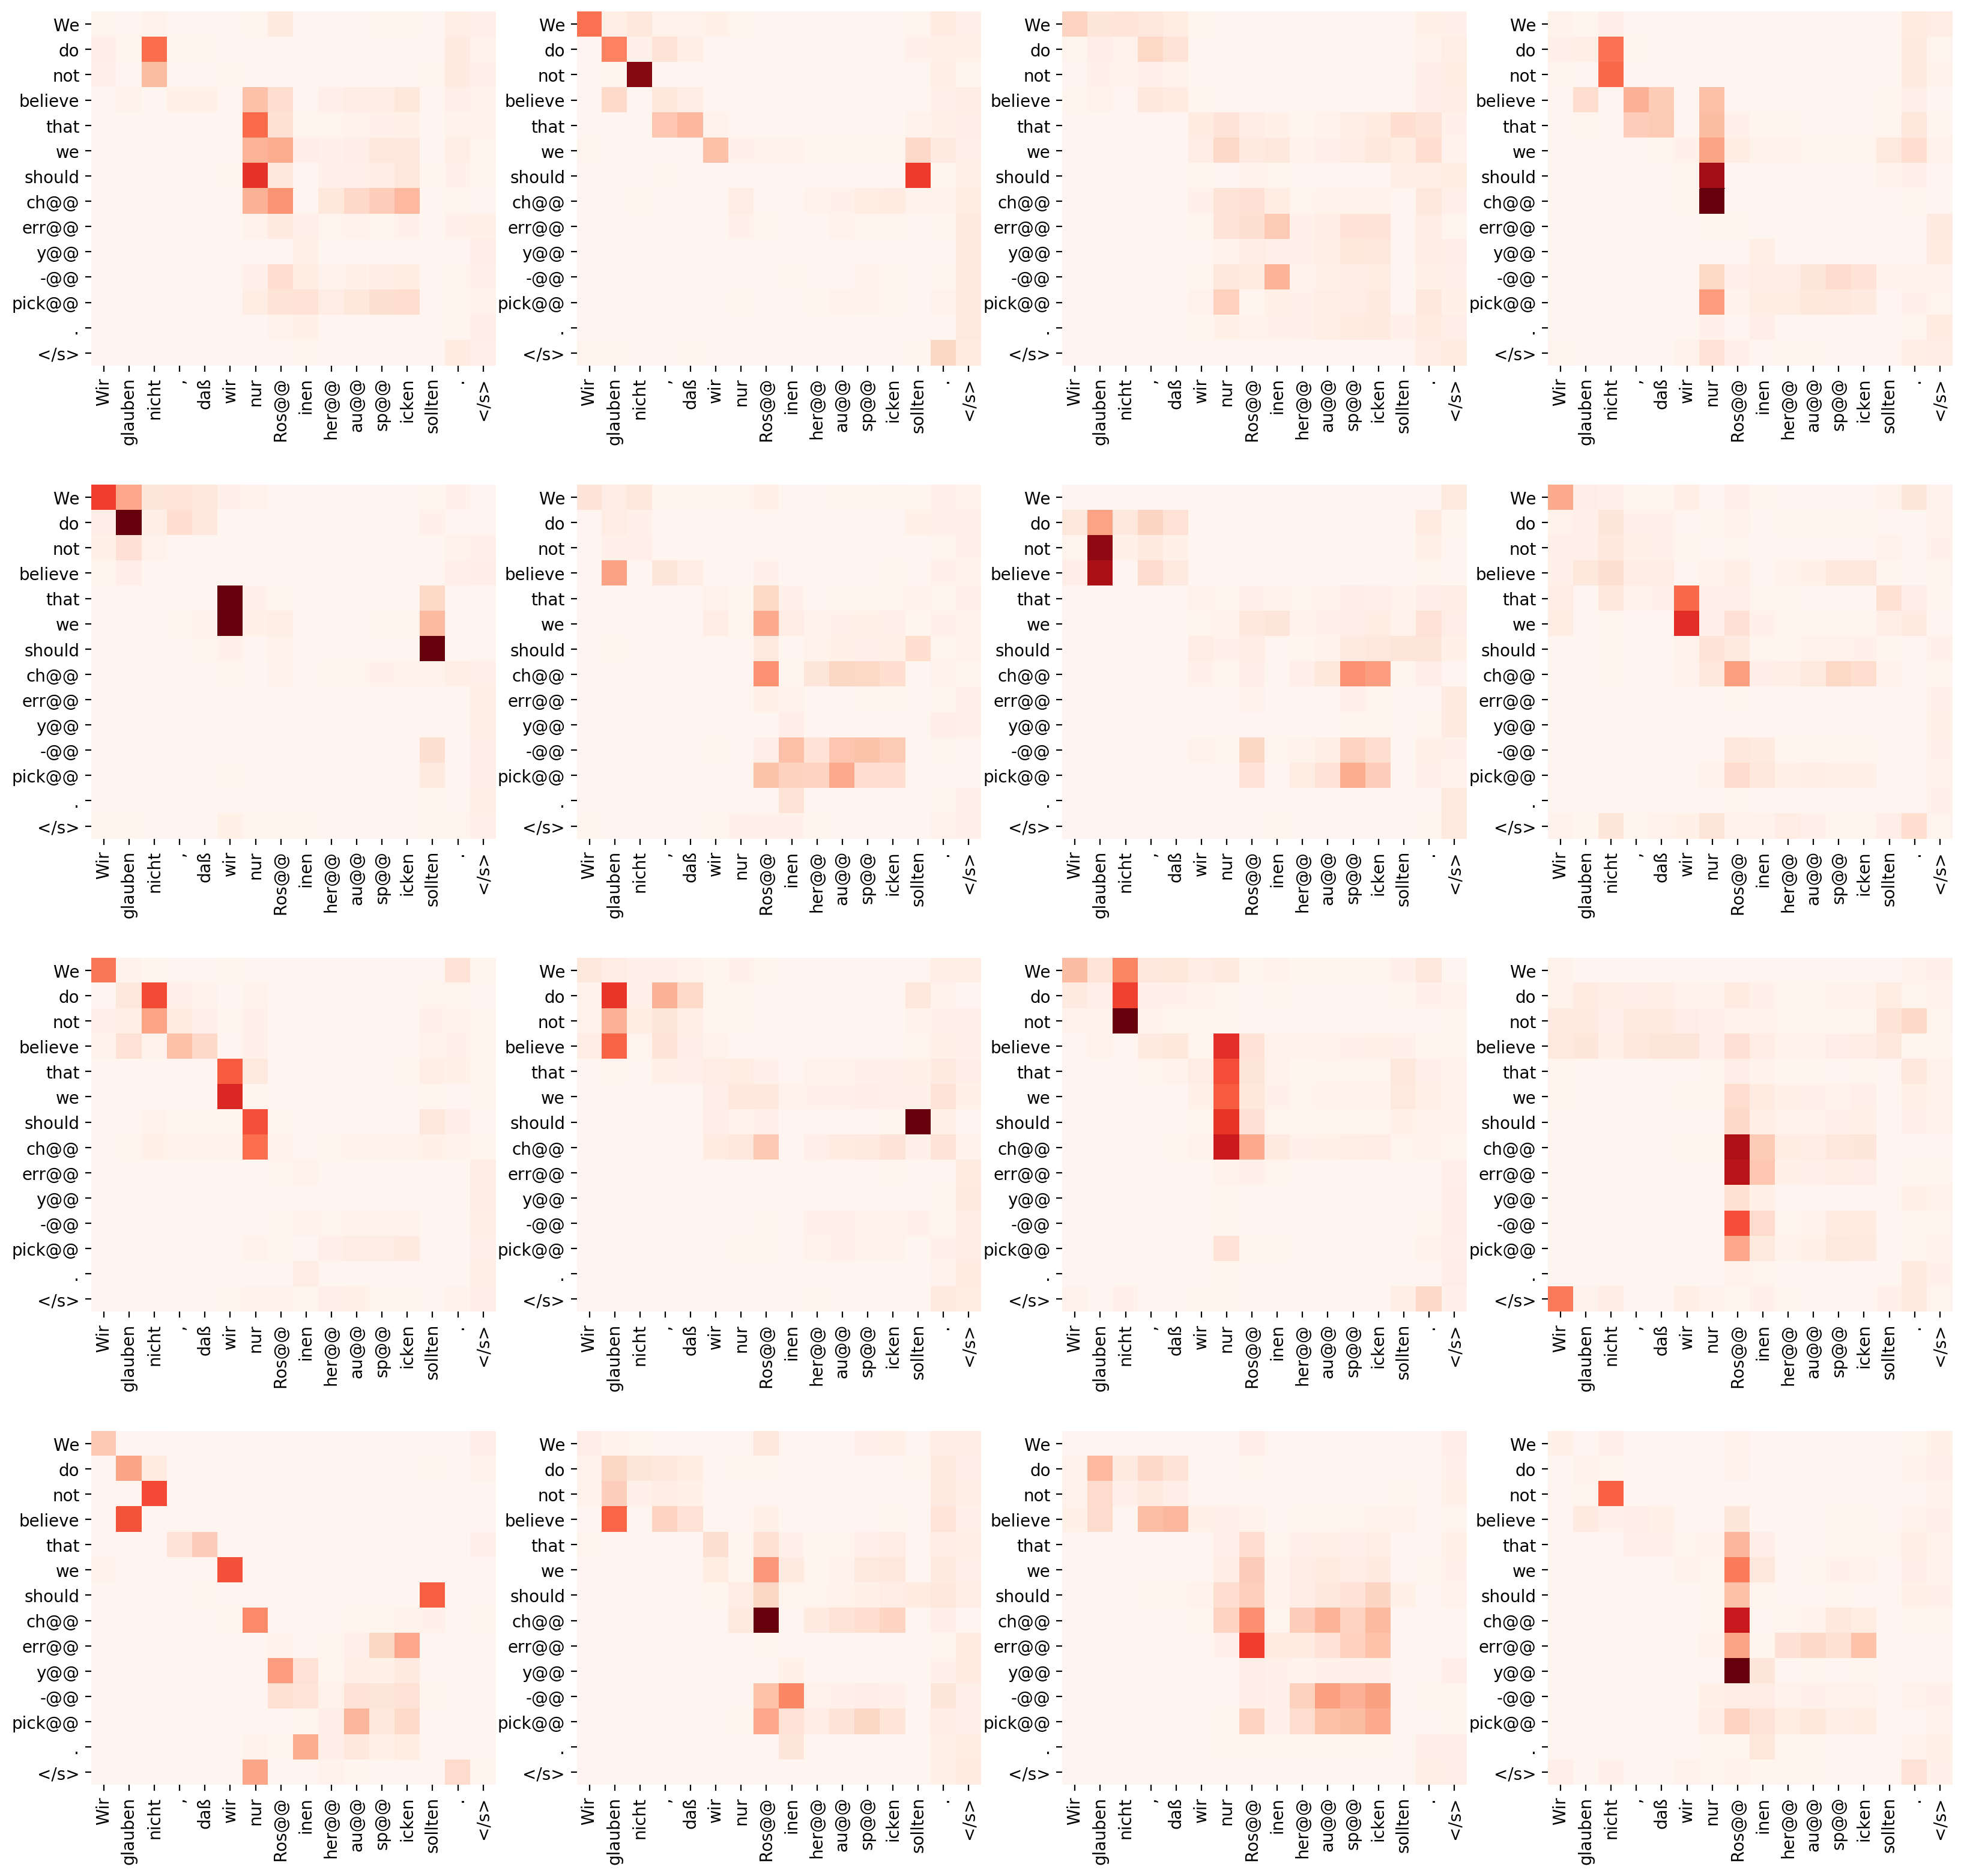


 6 layer


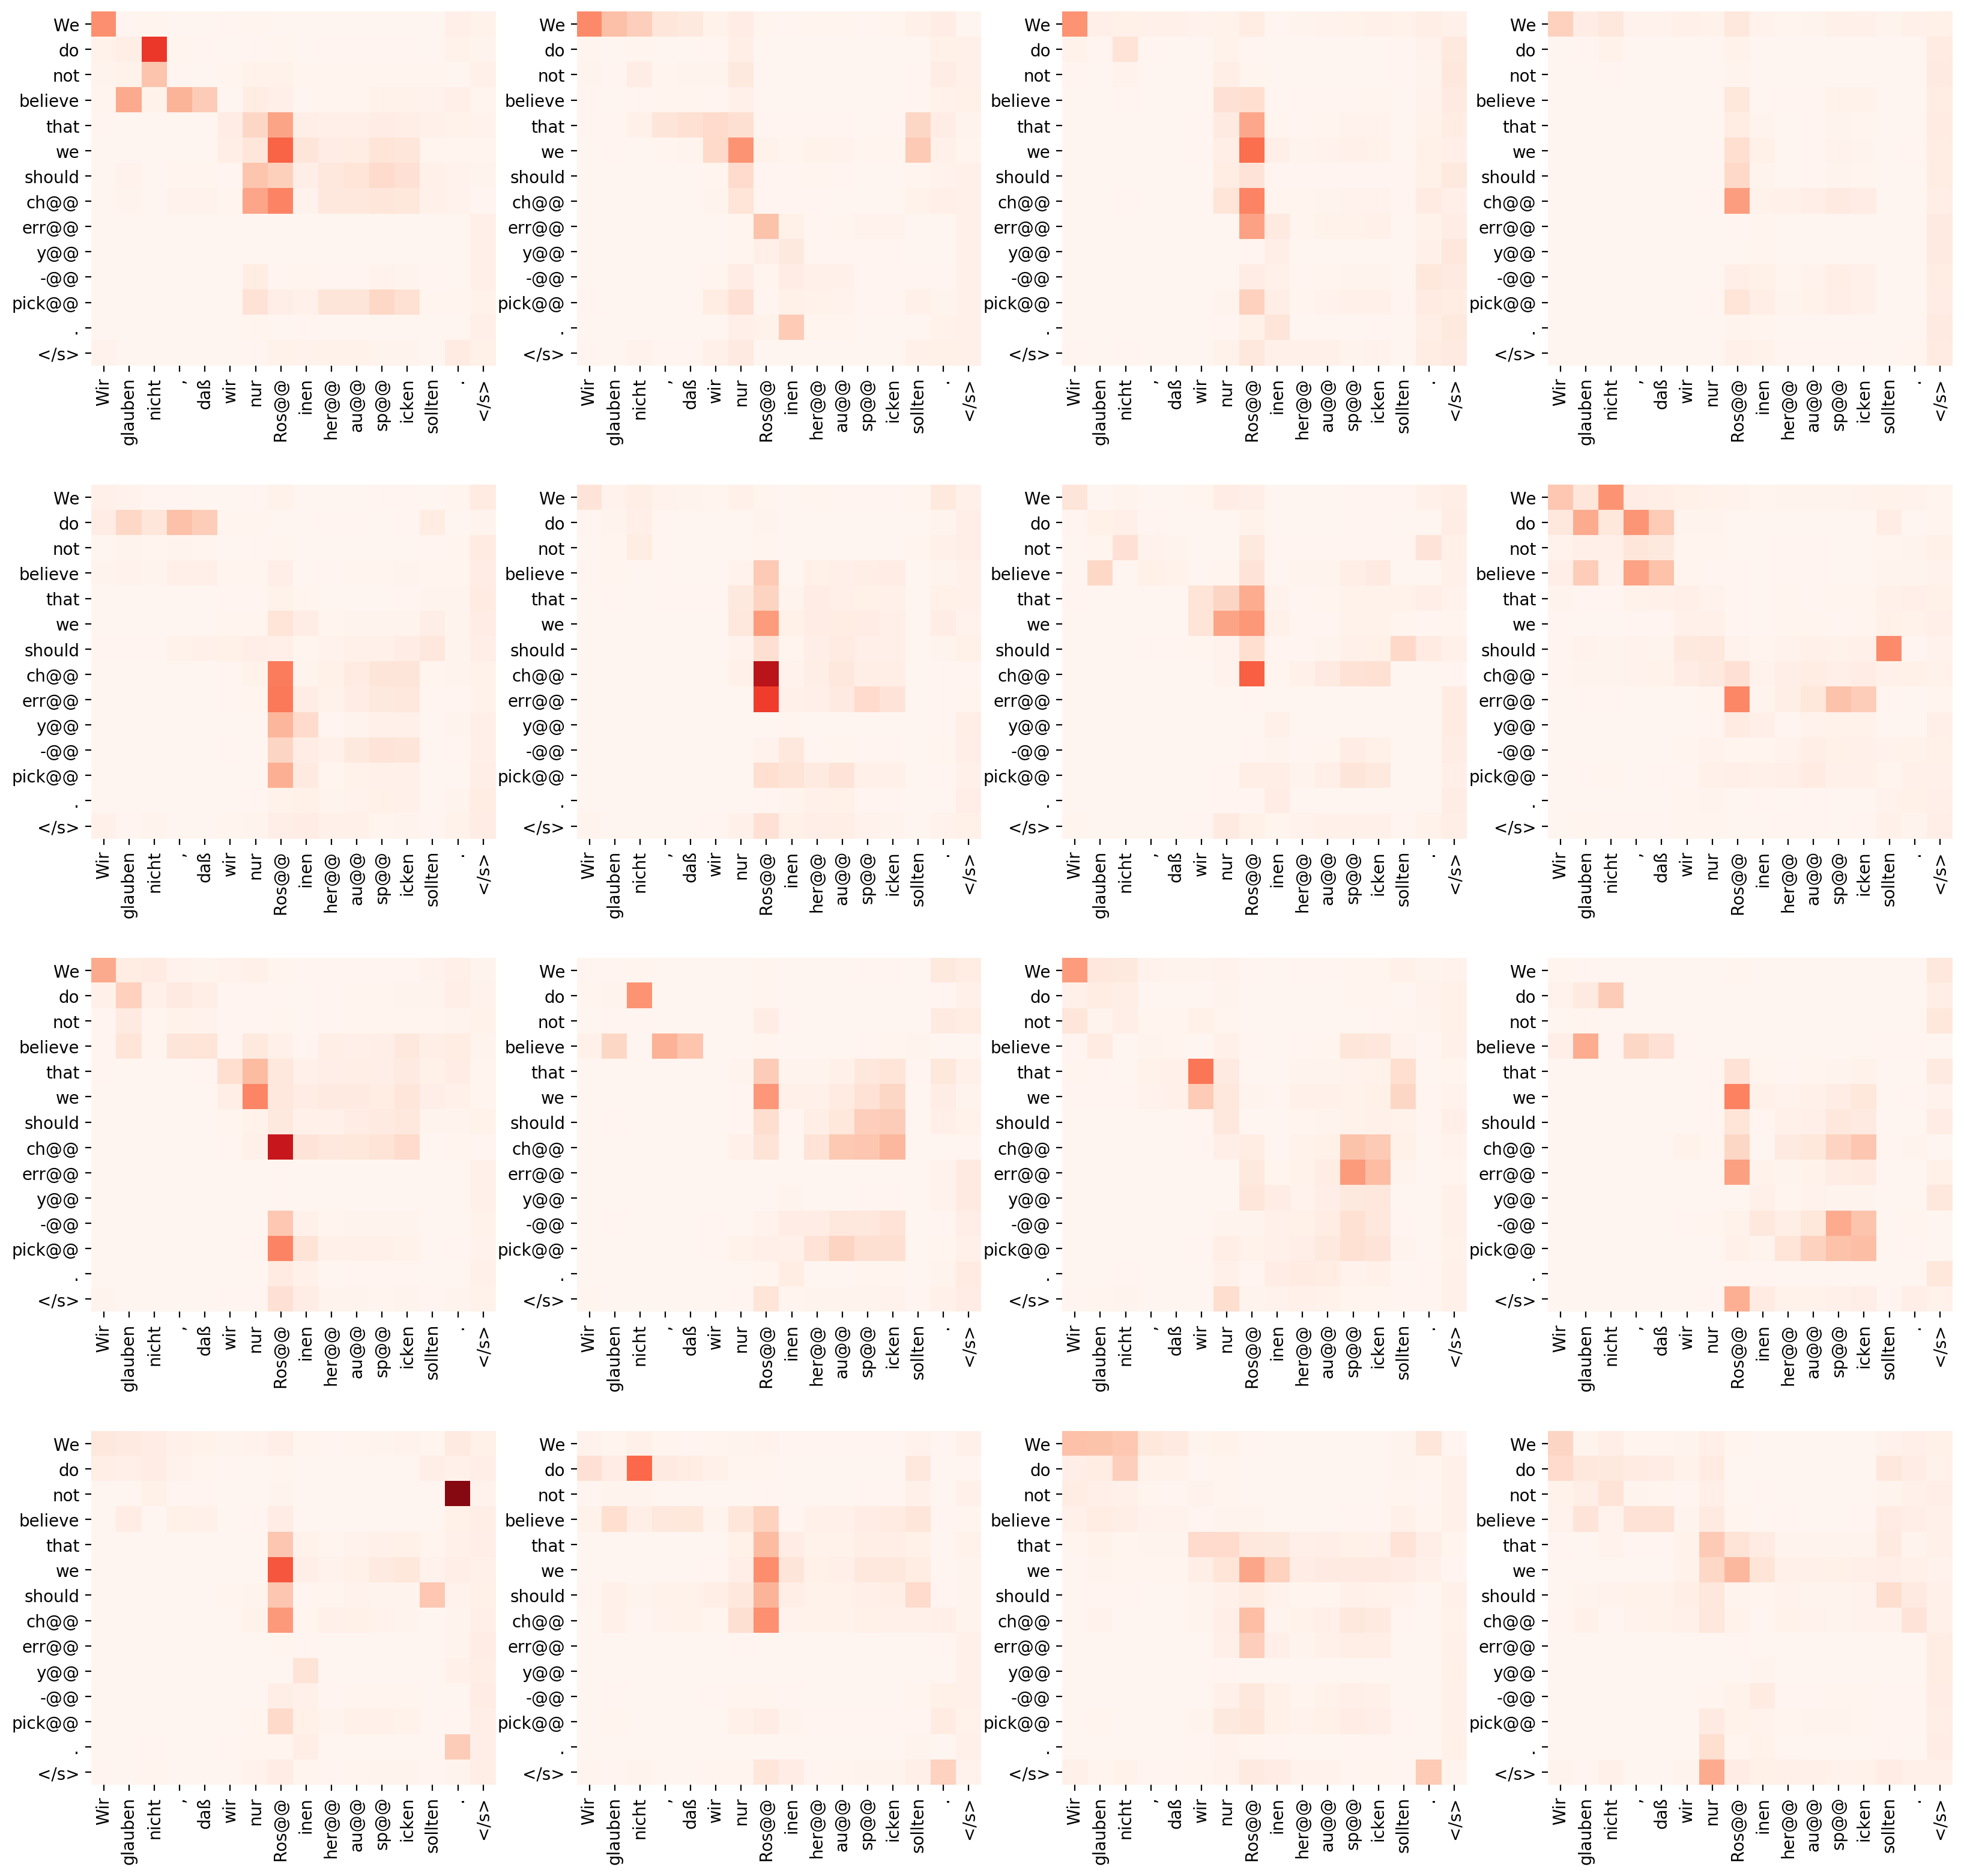

In [13]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

for layer in range(6):
    print("\n",layer+1,"layer")
    fig, axe = plt.subplots(4, 4, figsize=(20, 20), dpi=200)
    for head in range(16):
        norm = outputs[1]['norms'][1][layer][head,0].detach().cpu().numpy()
        df = pd.DataFrame(norm,columns=de_toks,index=en_toks[1:]+['</s>'])
        sns.heatmap(df,vmax=5,cmap="Reds",square=True,cbar=False,ax=axe[int(head/4)][head - int(head/4)*4])
    plt.show()    